# PART 4

## 0) IMPORTS

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pandas as pd
import pandas as pd
from datetime import datetime, timedelta
import json

## 1) MEMCACHED PERFORMANCE ANALYSIS

### plot1

In [24]:
# step 1 - take data from files
directory = './data4/memcached_performance_analysis/plot1'
all_lines = []
for dir in os.listdir(directory):
    p95_list = []
    QPS_list = []
    path = os.path.join(directory, dir)
    if os.path.isdir(path):
        for file in os.listdir(path):
            if file.endswith(".txt"):
                file_path = os.path.join(path, file)
                df = pd.read_csv(file_path,  sep='\s+')
                df = df[["p95", "QPS"]]
                df['p95'] = df["p95"]/1000
                df['QPS'] = df["QPS"]/1000
                p95_list.append(list(df["p95"]))
                QPS_list.append(list(df['QPS']))
        sum_p95 = [sum(x) for x in zip(*p95_list)]
        avg_p95 = [round(x / len(p95_list),2) for x in sum_p95]
        sum_QPS = [sum(x) for x in zip(*QPS_list)]
        avg_QPS = [round(x / len(QPS_list),2) for x in sum_QPS]

        p95_array = np.array(p95_list)
        QPS_array = np.array(QPS_list)
        p95_std = list(round(x,2) for x in np.std(p95_array, axis=0))
        QPS_std = list(round(x,2) for x in np.std(QPS_array, axis=0))
        all_lines.append([avg_p95, avg_QPS, p95_std, QPS_std])
avg_p95 = [line[0] for line in all_lines]
avg_QPS = [line[1] for line in all_lines]
p95_std = [line[2] for line in all_lines]
QPS_std = [line[3] for line in all_lines]

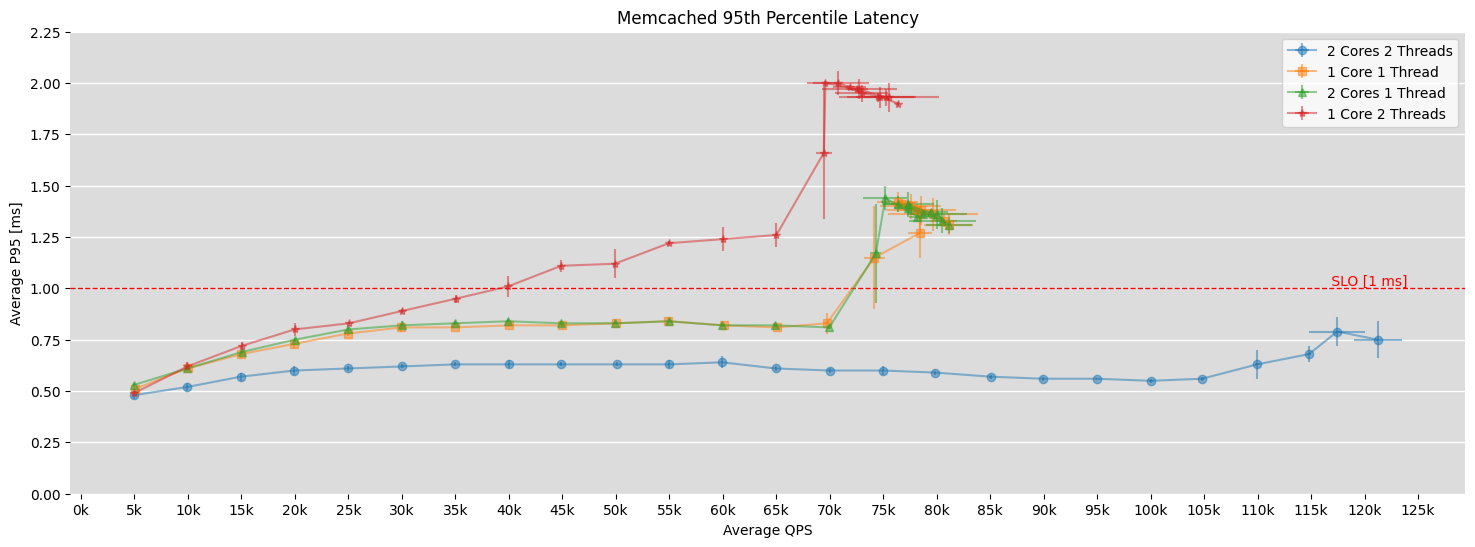

In [44]:
# step 2 - plot 
plt.figure(figsize=(18, 6))
labels = ['2 Cores 2 Threads', '1 Core 1 Thread','2 Cores 1 Thread', '1 Core 2 Threads']
fmt = ['o-','s-', '^-', '*-']
for i in range(len(avg_p95)):
    plt.errorbar(avg_QPS[i], avg_p95[i], xerr=QPS_std[i], yerr=p95_std[i], label=labels[i], fmt=fmt[i], alpha=0.5)

plt.axhline(y=1, color='red', linestyle='--', linewidth=1)
plt.text(max(plt.xlim())*0.90, 1, ' SLO [1 ms]', verticalalignment='bottom', color='red')
plt.xticks(range(0, 130, 5), [f'{x}k' for x in range(0, 130, 5)])
plt.ylim((0,2.25))

plt.xlabel('Average QPS')
plt.ylabel('Average P95 [ms]')
plt.title('Memcached 95th Percentile Latency')
plt.legend()
plt.gca().set_facecolor('gainsboro') 
plt.grid(True, which='major', axis='y', color='white', linestyle='-', linewidth=1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()

### plot2

##### 1C 2 T

In [66]:
# step 1 - preprocess data
def subtract_2_hours(timestamp):
    return timestamp - timedelta(hours=2)

memcached_df = pd.read_csv("./data4/memcached_performance_analysis/plot2/1C_2T/mem.txt", sep='\s+')
utilization_df = pd.read_csv("./data4/memcached_performance_analysis/plot2/1C_2T/util.txt")

memcached_df = memcached_df[['p95','QPS','ts_start','ts_end']]
memcached_df['ts_start'] = memcached_df['ts_start']/1000
memcached_df['ts_start'] = memcached_df['ts_start'].apply(lambda x: datetime.fromtimestamp(x).replace(microsecond=0)).apply(subtract_2_hours)
memcached_df['ts_end'] = memcached_df['ts_end']/1000
memcached_df['ts_end'] = memcached_df['ts_end'].apply(lambda x: datetime.fromtimestamp(x).replace(microsecond=0)).apply(subtract_2_hours)
utilization_df['TIME'] = pd.to_datetime(utilization_df['TIME']).dt.floor('s')
utilization_df= utilization_df[['TIME','C1','C2']]

final_df = pd.DataFrame(columns=['p95','QPS','C1','C2'])
for i,el in memcached_df.iterrows():
    riga=[]
    for x,elem in utilization_df.iterrows():
        if el['ts_start'] <= elem['TIME'] <= el['ts_end']:
            riga.append([elem['C1'], elem['C2']])
    if len(riga)>1:
        avg_result = np.mean(np.array(riga), axis=0)
        riga = avg_result.tolist()
    else:
        riga = riga[0]

    new_row = {'p95': el['p95']/1000, 'QPS': el['QPS']/1000, 'C1': riga[0], 'C2': riga[1]}
    new_row = pd.DataFrame(new_row, index=[0])
    final_df=pd.concat([final_df, new_row], ignore_index=True)

# utilization means the sum of the first 2 cores in this case
final_df['Ctot'] = final_df['C1']


/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_55264/2954268575.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df=pd.concat([final_df, new_row], ignore_index=True)


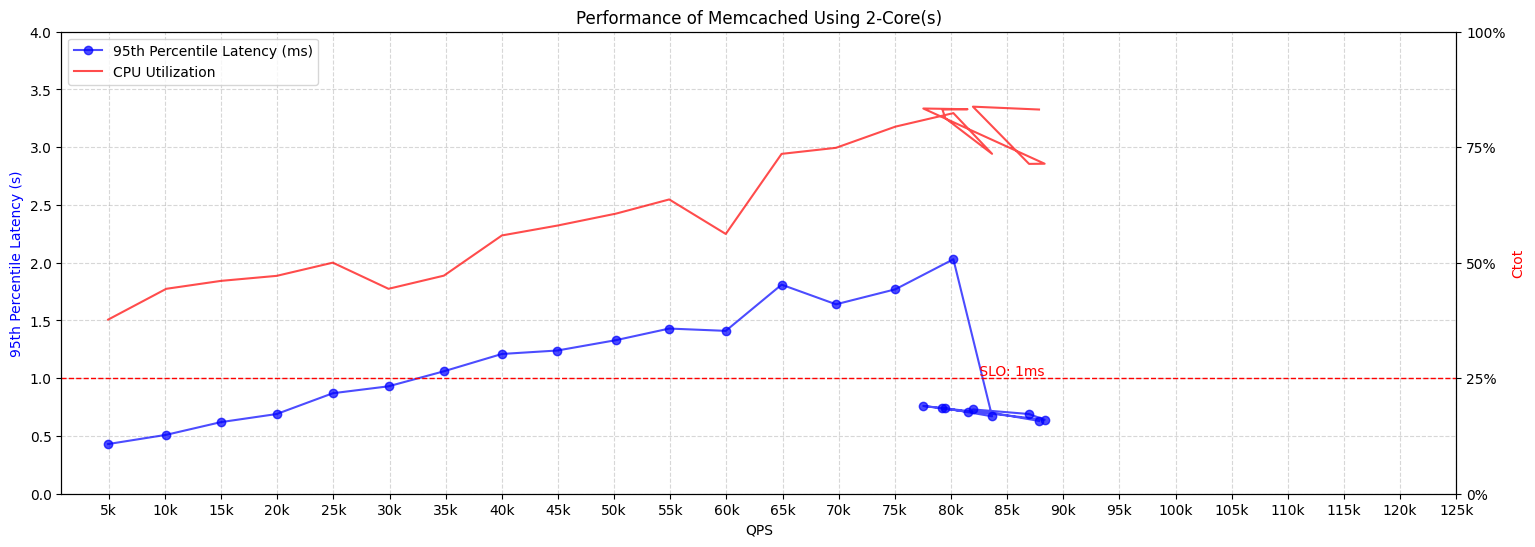

In [67]:
# step 2 - plot
df = final_df
fig, ax1 = plt.subplots(figsize = (18,6))

# p95 plpt
ax1.plot(df['QPS'], round(df['p95'],2), 'o-', label='95th Percentile Latency (ms)', alpha=0.7, color='blue')
ax1.set_ylim((0,4))
ax1.axhline(y=1, color='red', linestyle='--', linewidth=1)
ax1.text(df['QPS'].max(), 1, ' SLO: 1ms', verticalalignment='bottom', horizontalalignment='right', color='red')
ax1.set_title(f'Performance of Memcached Using 2-Core(s)')
ax1.set_xlabel('Achieved QPS')
ax1.set_ylabel('95th Percentile Latency (s)', color='blue')

# utilization plot
ax2 = ax1.twinx()
ax2.set_ylabel('CPU Utilization (%)')
ax2.plot(df['QPS'], df['Ctot'], 'r-', label='CPU Utilization', alpha=0.7)
ax1.set_xlabel('QPS')
ax2.set_ylabel('Ctot', color='red')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
ax1.grid(True, which='both', linestyle='--', alpha=0.5)
ax1.set_xticks(range(5, 130, 5))
ax1.set_xticklabels([f'{int(x)}k' for x in range(5, 130, 5)])
ax2.set_yticks(range(0, 125, 25))
ax2.set_yticklabels([f'{int(x)}%' for x in range(0, 125, 25)])

plt.show()

##### 2C 2T

In [62]:
# step 1 - preprocess data
def subtract_2_hours(timestamp):
    return timestamp - timedelta(hours=2)

memcached_df = pd.read_csv("./data4/memcached_performance_analysis/plot2/2C_2T/mem.txt", sep='\s+')
utilization_df = pd.read_csv("./data4/memcached_performance_analysis/plot2/2C_2T/util.txt")

memcached_df = memcached_df[['p95','QPS','ts_start','ts_end']]
memcached_df['ts_start'] = memcached_df['ts_start']/1000
memcached_df['ts_start'] = memcached_df['ts_start'].apply(lambda x: datetime.fromtimestamp(x).replace(microsecond=0)).apply(subtract_2_hours)
memcached_df['ts_end'] = memcached_df['ts_end']/1000
memcached_df['ts_end'] = memcached_df['ts_end'].apply(lambda x: datetime.fromtimestamp(x).replace(microsecond=0)).apply(subtract_2_hours)
utilization_df['TIME'] = pd.to_datetime(utilization_df['TIME']).dt.floor('s')
utilization_df= utilization_df[['TIME','C1','C2']]

final_df = pd.DataFrame(columns=['p95','QPS','C1','C2'])
for i,el in memcached_df.iterrows():
    riga=[]
    for x,elem in utilization_df.iterrows():
        if el['ts_start'] <= elem['TIME'] <= el['ts_end']:
            riga.append([elem['C1'], elem['C2']])
    if len(riga)>1:
        avg_result = np.mean(np.array(riga), axis=0)
        riga = avg_result.tolist()
    else:
        riga = riga[0]

    new_row = {'p95': el['p95']/1000, 'QPS': el['QPS']/1000, 'C1': riga[0], 'C2': riga[1]}
    new_row = pd.DataFrame(new_row, index=[0])
    final_df=pd.concat([final_df, new_row], ignore_index=True)

# utilization means the sum of the first 2 cores in this case
final_df['Ctot'] = final_df['C1'] + final_df['C2']


/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_55264/2716203591.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df=pd.concat([final_df, new_row], ignore_index=True)


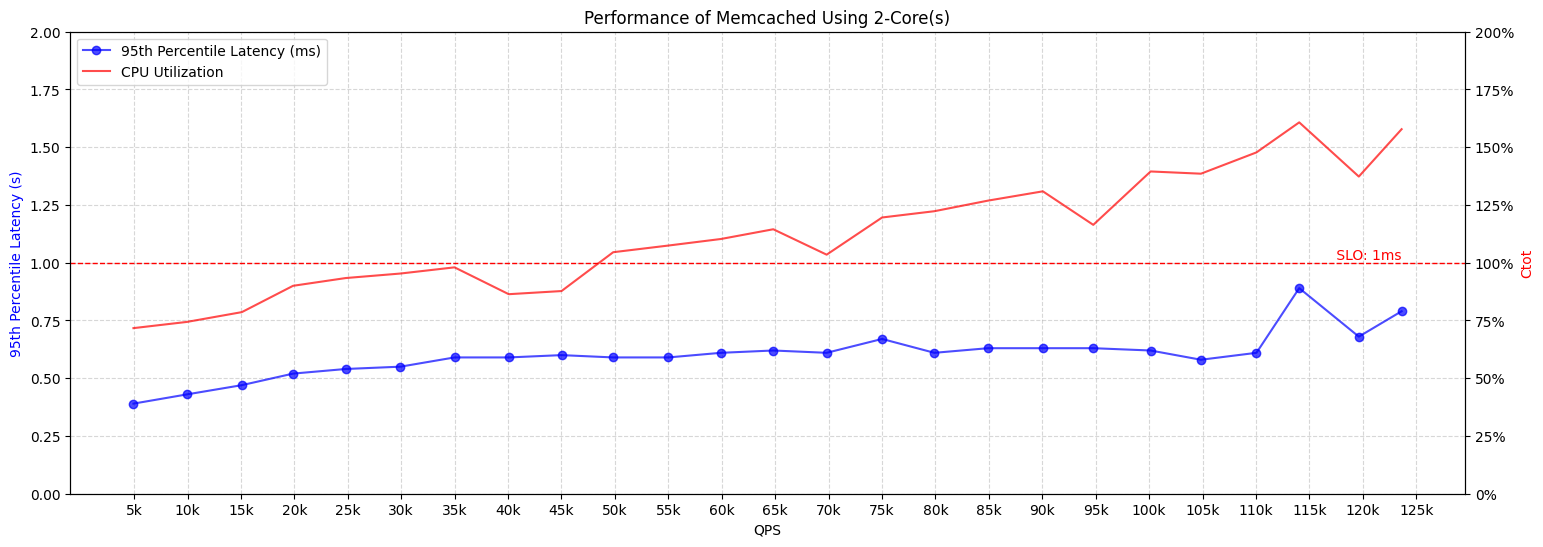

In [63]:
# step 1 - preprocess data
df = final_df
fig, ax1 = plt.subplots(figsize = (18,6))

# p95 plot
ax1.plot(df['QPS'], round(df['p95'],2), 'o-', label='95th Percentile Latency (ms)', alpha=0.7, color='blue')
ax1.set_ylim((0,2))
ax1.axhline(y=1, color='red', linestyle='--', linewidth=1)
ax1.text(df['QPS'].max(), 1, ' SLO: 1ms', verticalalignment='bottom', horizontalalignment='right', color='red')
ax1.set_title(f'Performance of Memcached Using 2-Core(s)')
ax1.set_xlabel('Achieved QPS')
ax1.set_ylabel('95th Percentile Latency (s)', color='blue')

# utilization plot
ax2 = ax1.twinx()
ax2.set_ylabel('CPU Utilization (%)')
ax2.plot(df['QPS'], df['Ctot'], 'r-', label='CPU Utilization', alpha=0.7)
ax1.set_xlabel('QPS')
ax2.set_ylabel('Ctot', color='red')
ax2.set_ylim((0,200))
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

ax1.set_xticks(range(5, 130, 5))
ax1.set_xticklabels([f'{int(x)}k' for x in range(5, 130, 5)])
ax2.set_yticks(range(0, 225, 25))
ax2.set_yticklabels([f'{int(x)}%' for x in range(0, 225, 25)])

plt.show()

## 2) DYNAMIC SCHEDULING WITH RANDOM SEED

####  2.1 - PREPROCESSING

##### 2.1.1 - job preprocessing

In [74]:
# step 1 - jobs preprocessing

# utility functions
def subtract_2_hours(timestamp):
    # what: subtract 2 hours from timestamp
    # why: noticed that mcperf and pods timestamps are off by 2 hours -> solution subtract 2 hours
    return timestamp - timedelta(hours=2)

def merge_start_finish_times(start_times, finish_times,job, s, e, general,st, run):
    # from raw data: start, finish, start pause, end pause -> extract timestamps where job is running
    job['pauses']={}
    start_index = 0
    finish_index = 0
    i = -1
    if len(finish_times)> len(start_times):
        start_times.insert(0, st)
    if len(start_times)> len(finish_times):
        start_times=start_times[:-1]
    while start_index <= len(start_times) and finish_index <= len(finish_times):
        i += 1
        finish_time = finish_times[finish_index]
        if start_index == len(start_times):
            f = finish_time - general
            f = f.total_seconds()
            job['pauses'][i] = (f, e)
            break
        start_time = start_times[start_index]

        if start_index == 0:
            staart = start_time - general
            staart = staart.total_seconds()
            job['pauses'][i] = (s, staart)
        if start_index != 0 and start_index != len(start_times):
            f = finish_time - general
            f = f.total_seconds()
            staart = start_time - general
            staart = staart.total_seconds()
            if run=='1':
                job['pauses'][i] = (f+2, staart)
            else: 
                job['pauses'][i] = (f+2, staart)
            finish_index += 1
        start_index += 1
    return job['pauses']

def job_preprocessing(run):
    path = './data4/scheduling/42/'+run+'/times_1.json'
    with open(path) as file:
        data = json.load(file)
    total=[]
    jobs = {}
    mem_to_1 = []
    mem_to_2 = []
    switch = 0
    total_t = []
    for job_name, job_data in data.items():
        if job_name == 'total':
            # total is the total makespan
            # start of first job
            start = datetime.fromtimestamp(float(job_data['start'])).replace(microsecond=0)
            start = subtract_2_hours(start)
            total_t.append(start)
            general_s= start
            start = start - general_s
            start = start.total_seconds()
            # end of all jobs
            end = datetime.fromtimestamp(float(job_data['finish'])).replace(microsecond=0)
            end = subtract_2_hours(end)
            total_t.append(end)
            end = end - general_s
            end = end.total_seconds()
            total.append(start)
            total.append(end)

        if job_name != 'total' and job_name != 'mem' and job_name != 'cpu' and job_name != 'pauses' and job_name != 'switch_job_1':
            if job_name == 'vips':
                # vips has the problem that it is the last job to end so the end is the same as total end
                # start from the file
                start = datetime.fromtimestamp(float(job_data['start'])).replace(microsecond=0)
                start = subtract_2_hours(start)
                start = start - general_s
                start = start.total_seconds()
                # fix end as total end
                job = {
                'start': start,
                'finish': total[1]
                }
            else:
                # start from the file
                start = datetime.fromtimestamp(float(job_data['start'])).replace(microsecond=0)
                start_t = subtract_2_hours(start)
                start = start_t - general_s
                start = start.total_seconds()
                # end from the file
                end = datetime.fromtimestamp(float(job_data['finish'])).replace(microsecond=0)
                end_t = subtract_2_hours(end)
                end = end_t - general_s
                end = end.total_seconds()
                job = {
                'start': start,
                'finish': end
                }
                if 'pauses' in job_data:
                    f = True
                    pauses = job_data['pauses']
                    if 'pause' in pauses:
                        if pauses['pause'] ==[]:
                            f = False
                        pauses_a = [ datetime.fromtimestamp(float(pause)).replace(microsecond=0) for pause in pauses['pause']]
                        pausess = [ subtract_2_hours(p) for p in pauses_a]
                    if 'unpause' in pauses:
                        if pauses['unpause'] ==[]:
                            f = False
                        unpauses_a = [ datetime.fromtimestamp(float(unpause)).replace(microsecond=0) for unpause in pauses['unpause']]
                        unpausess = [ subtract_2_hours(p) for p in unpauses_a]
                    # this computes the job intervals when the job is running
                    if f:
                        job['pauses'] = merge_start_finish_times(pausess, unpausess, job, start, end, general_s, start_t, run)
            jobs[job_name] = job
        if job_name == 'mem':
            one = job_data['to_1']
            one_a = [ datetime.fromtimestamp(float(o)).replace(microsecond=0) for o in one]
            mem_to_1 = [ (subtract_2_hours(o)- general_s).total_seconds() for o in one_a]
            two = job_data['to_2']
            two_a = [ datetime.fromtimestamp(float(t)).replace(microsecond=0) for t in two]
            mem_to_2 = [ (subtract_2_hours(t)- general_s).total_seconds() for t in two_a]
        if job_name == 'switch_job_1':
            t = datetime.fromtimestamp(float(job_data)).replace(microsecond=0)
            t = subtract_2_hours(t)
            t = t - general_s
            t = t.total_seconds()
            switch = t
    return mem_to_1,mem_to_2, switch,jobs, total, total_t

total_jobs=[]
total_mem_to = []
total_switch=[]
total=[]
total_t=[]
for i, run in enumerate(['1','2','3']):
    mem_to_1,mem_to_2, switch,jobs, totali, total_ti = job_preprocessing(run)
    total_jobs.append(jobs)
    print("Job Information:")
    for job_name, job in jobs.items():
        print(f"{job_name}:")
        print(f"Start Time: {job['start']}")
        print(f"Finish Time: {job['finish']}")
        if 'pauses' in job:
            print("Pauses:")
            for pause_time in job['pauses']:
                print(f"  {pause_time}:", job['pauses'][pause_time])

    mem_df = pd.DataFrame({'timestamp': mem_to_1 + mem_to_2, 'value': [1] * len(mem_to_1) + [2] * len(mem_to_2)})
    mem_df.sort_values(by='timestamp', inplace=True)
    print(mem_df)
    total_mem_to.append(mem_df)
    total_switch.append(switch)
    total.append(totali)
    total_t.append(total_ti)
print(total)

Job Information:
black:
Start Time: 449.0
Finish Time: 550.0
canneal:
Start Time: 449.0
Finish Time: 716.0
dedup:
Start Time: 0.0
Finish Time: 541.0
Pauses:
  0: (0.0, 0.0)
  1: (6.0, 7.0)
  2: (11.0, 11.0)
  3: (47.0, 46.0)
  4: (52.0, 50.0)
  5: (85.0, 86.0)
  6: (90.0, 91.0)
  7: (95.0, 94.0)
  8: (140.0, 138.0)
  9: (149.0, 151.0)
  10: (179.0, 177.0)
  11: (182.0, 181.0)
  12: (229.0, 227.0)
  13: (236.0, 235.0)
  14: (239.0, 238.0)
  15: (242.0, 240.0)
  16: (254.0, 252.0)
  17: (256.0, 255.0)
  18: (259.0, 258.0)
  19: (265.0, 271.0)
  20: (331.0, 329.0)
  21: (396.0, 395.0)
  22: (399.0, 398.0)
  23: (449.0, 448.0)
  24: (517.0, 516.0)
  25: (523.0, 521.0)
  26: (535.0, 533.0)
  27: (539.0, 541.0)
ferret:
Start Time: 0.0
Finish Time: 189.0
freqmine:
Start Time: 190.0
Finish Time: 448.0
radix:
Start Time: 542.0
Finish Time: 728.0
Pauses:
  0: (542.0, 545.0)
  1: (547.0, 547.0)
  2: (549.0, 561.0)
  3: (561.0, 600.0)
  4: (602.0, 625.0)
  5: (627.0, 627.0)
  6: (629.0, 647.0)
  7

##### 2.1.2 - mcperf preprocessing

In [75]:
# step 2 - mcperf preprocessing
# utitity functions
def subtract_2_hours(timestamp):
    # what: subtract 2 hours from timestamp
    # why: noticed that mcperf and pods timestamps are off by 2 hours -> solution subtract 2 hours
    return timestamp - timedelta(hours=2)

def read_mcperf_data(folder):
    # what: preprocessing of mcperf data
    mcperf_path = os.path.join('data4/scheduling/42', folder, 'mem.txt')
    with open(mcperf_path, 'r') as file:
        start_timestamp = int(file.readline().split(': ')[1])
        end_timestamp = int(file.readline().split(': ')[1])
    
    df = pd.read_csv(mcperf_path, skiprows=2, sep='\s+')
    total_seconds = (end_timestamp - start_timestamp) / 1000
    num_rows = len(df)
    interval_seconds = total_seconds / num_rows
    df['ts_start'] = start_timestamp / 1000
    df['ts_end'] = df['ts_start'] + interval_seconds

    # Update ts_start and ts_end for each row
    for i in range(1, num_rows):
        df.at[i, 'ts_start'] = df.at[i-1, 'ts_end']
        df.at[i, 'ts_end'] = df.at[i, 'ts_start'] + interval_seconds
    # all in seconds
    df['p95'] = df['p95'] / 1000

    # have a timestamp for both start and end (needed for synchronization)
    df['start_timestamp'] = df['ts_start'].apply(lambda x: datetime.fromtimestamp(x).replace(microsecond=0))
    df['end_timestamp'] = df['ts_end'].apply(lambda x: datetime.fromtimestamp(x).replace(microsecond=0))
    df['start_timestamp'] = df['start_timestamp'].apply(subtract_2_hours)
    df['end_timestamp'] = df['end_timestamp'].apply(subtract_2_hours)
    print(df)
    return df



def cut_df(mcperf,total):
    # this function cuts off the parts of the mcperf file(/df) that are not neeeded because they are not relative to the makespan of the jobs
    # notice that first the times are synchronized

    # step 1 - identify the interval of interest
    # min start time of all jobs
    min_time = total[0]
    # max end time of all jobs
    max_time = total[1]

    # step 2 - pick indices of mcperf intervall in which the min start time takes place
    # condition: min start time is greater than the start interval and smaller than the end interval
    indici_pre_min = mcperf.loc[mcperf['start_timestamp'] <= min_time].index
    indici_post_min = mcperf.loc[mcperf['end_timestamp']>=min_time].index
    common_min_indices = set(indici_pre_min).intersection(indici_post_min)
    first_common_min_index = min(common_min_indices)
    
    # step 3 - pick indices of mcperf intervall in which the max end time takes place
    # condition: max end time is greater than the start interval and smaller than the end interval
    indici_pre_max = mcperf.loc[mcperf['start_timestamp'] <= max_time].index
    indici_post_max = mcperf.loc[mcperf['end_timestamp']>=max_time].index
    common_max_indices = set(indici_pre_max).intersection(indici_post_max)
    first_common_max_index = min(common_max_indices)

    # step 4 - we have the first index to consider and the last one, we slice the df accordingly
    sliced_df = mcperf.iloc[first_common_min_index:first_common_max_index + 2]
    dist =  min_time - mcperf.iloc[first_common_min_index]['start_timestamp']
    return sliced_df, dist

# thic contains mcperf data WITHOUT syncrhonization
all_mcperf_data = []
# this contains mcperf data WITH synchronization
all_mcperf_data2=[]
# this contains the distance betweeen the min start of the pod and the start of the mcperf interval
distances =[]

for i, run in enumerate(['1','2','3']):
    mcperf = read_mcperf_data(run)
    all_mcperf_data.append(mcperf)
    sliced_df, dist = cut_df(mcperf,total_t[i])
    all_mcperf_data2.append(sliced_df)
    distances.append(dist)

   #type    avg     std    min     p5    p10    p50    p67    p75    p80  ...  \
0   read  522.5  1270.5  160.7  215.8  237.4  364.5  414.3  444.2  467.0  ...   
1   read  437.0   500.0  148.8  203.3  218.7  348.9  428.5  479.2  519.7  ...   
2   read  428.8   477.4  148.8  206.9  223.4  355.5  430.3  476.4  512.6  ...   
3   read  414.8   365.6  148.8  202.6  217.3  347.1  428.3  478.0  516.6  ...   
4   read  415.1   353.5  148.8  199.0  213.4  344.4  449.5  509.4  549.0  ...   
..   ...    ...     ...    ...    ...    ...    ...    ...    ...    ...  ...   
95  read  374.4   196.1  148.8  202.1  217.0  336.3  410.5  456.4  490.3  ...   
96  read  400.7   281.2  148.8  205.9  221.9  378.3  470.6  506.2  529.4  ...   
97  read  397.3   610.5  148.8  210.6  227.3  384.7  451.5  480.2  498.6  ...   
98  read  376.0   205.7  148.8  203.6  218.6  336.4  411.4  457.5  492.0  ...   
99  read  390.6   473.5  160.7  239.3  266.9  352.6  381.5  397.7  409.9  ...   

       p95     p99     p999

##### 2.1.3 - pods processing

In [76]:
# utitity functions
def subtract_2_hours(timestamp):
    # what: subtract 2 hours from timestamp
    # why: noticed that mcperf and pods timestamps are off by 2 hours -> solution subtract 2 hours
    return timestamp - timedelta(hours=2)

def read_mcperf_data(folder):
    # what: preprocessing of mcperf data
    mcperf_path = os.path.join('data1', folder, 'mcperf.txt')

    # take only these columns
    columns = ['p95', 'QPS', 'ts_start', 'ts_end']
    df = pd.read_csv(mcperf_path, delim_whitespace=True, usecols=columns)

    # all in seconds
    df['p95'] = df['p95'] / 1000
    df['ts_end'] = df['ts_end']/1000
    df['ts_start'] = df['ts_start']/1000

    # have a timestamp for both start and end (needed for synchronization)
    df['start_timestamp'] = df['ts_start'].apply(lambda x: datetime.fromtimestamp(x).replace(microsecond=0))
    df['end_timestamp'] = df['ts_end'].apply(lambda x: datetime.fromtimestamp(x).replace(microsecond=0))
    df['start_timestamp'] = df['start_timestamp'].apply(subtract_2_hours)
    df['end_timestamp'] = df['end_timestamp'].apply(subtract_2_hours)
    return df

def read_pods_data(folder):
    # what: preprocessing of pods data
    pods_path = os.path.join('data1', folder, 'pods.txt')
    with open(pods_path, 'r') as file:
        lines = file.readlines()
    jobs = []
    start_times = []
    end_times = []
    total_times = []
    abs_start_times = []
    abs_end_times = []
    # since jobs are printed by time, the min start time is the start time of the first job
    min_start_time = pd.to_datetime(lines[1].split(': ')[1].strip())
    for i in range(0, len(lines), 5):
        job_line = lines[i].strip()
        if job_line.startswith("Job:"):
            job = job_line.split(': ')[1].strip()
            # absolute start time = start time in the file
            start_time = pd.to_datetime(lines[i+1].split(': ')[1].strip())
            abs_start_times.append(start_time)

            # absolute end time = end time in the file
            end_time = pd.to_datetime(lines[i+2].split(': ')[1].strip())
            abs_end_times.append(end_time)

            # total time 
            total_time = pd.to_datetime(lines[i+3].split(': ')[1].strip())

            # relative start time = start time wrt min start time in seconds
            start_time = (start_time - min_start_time).total_seconds()

            # relative end time = end time wrt min start time in seconds
            end_time = (end_time - min_start_time).total_seconds()

            jobs.append(job)
            start_times.append(start_time)
            end_times.append(end_time)
            total_times.append(total_time.hour * 3600 + total_time.minute * 60 + total_time.second)
    df = pd.DataFrame({'Job': jobs, 'Start Time': start_times, 'End Time': end_times, 'Tot Time': total_times, 'abs_start_time': abs_start_times, 'abs_end_time': abs_end_times})
    return df

all_pods_data = []
for run_folder in ['run1', 'run2', 'run3']:

    pods = read_pods_data(run_folder)
    all_pods_data.append(pods)



#### 2.2 - PLOT

### plot A

/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_55264/1116199806.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


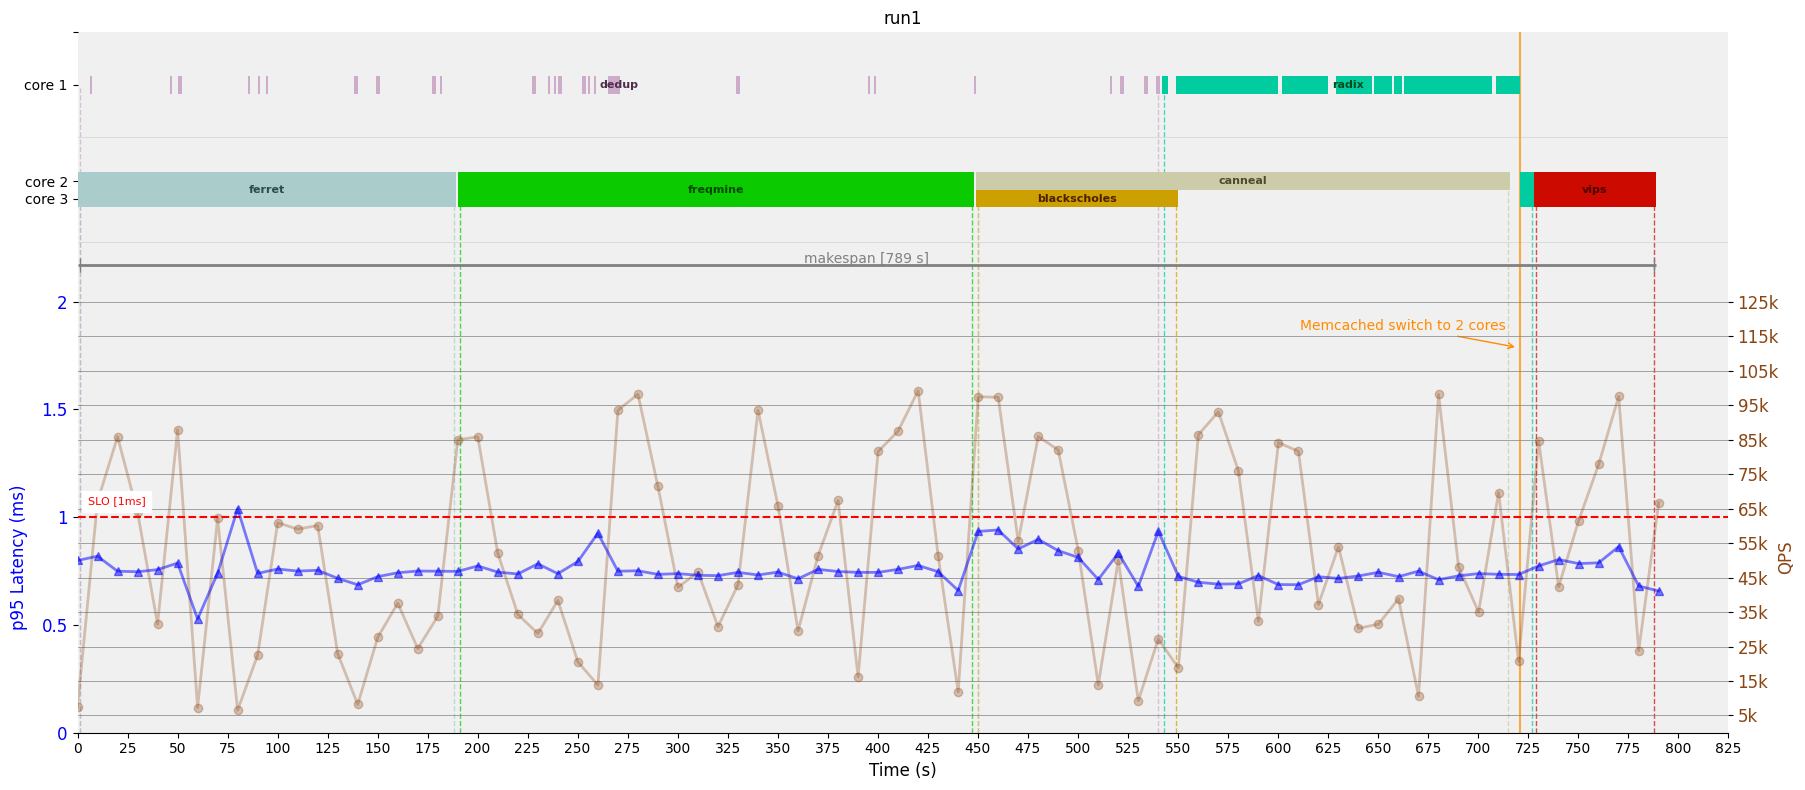

/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_55264/1116199806.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


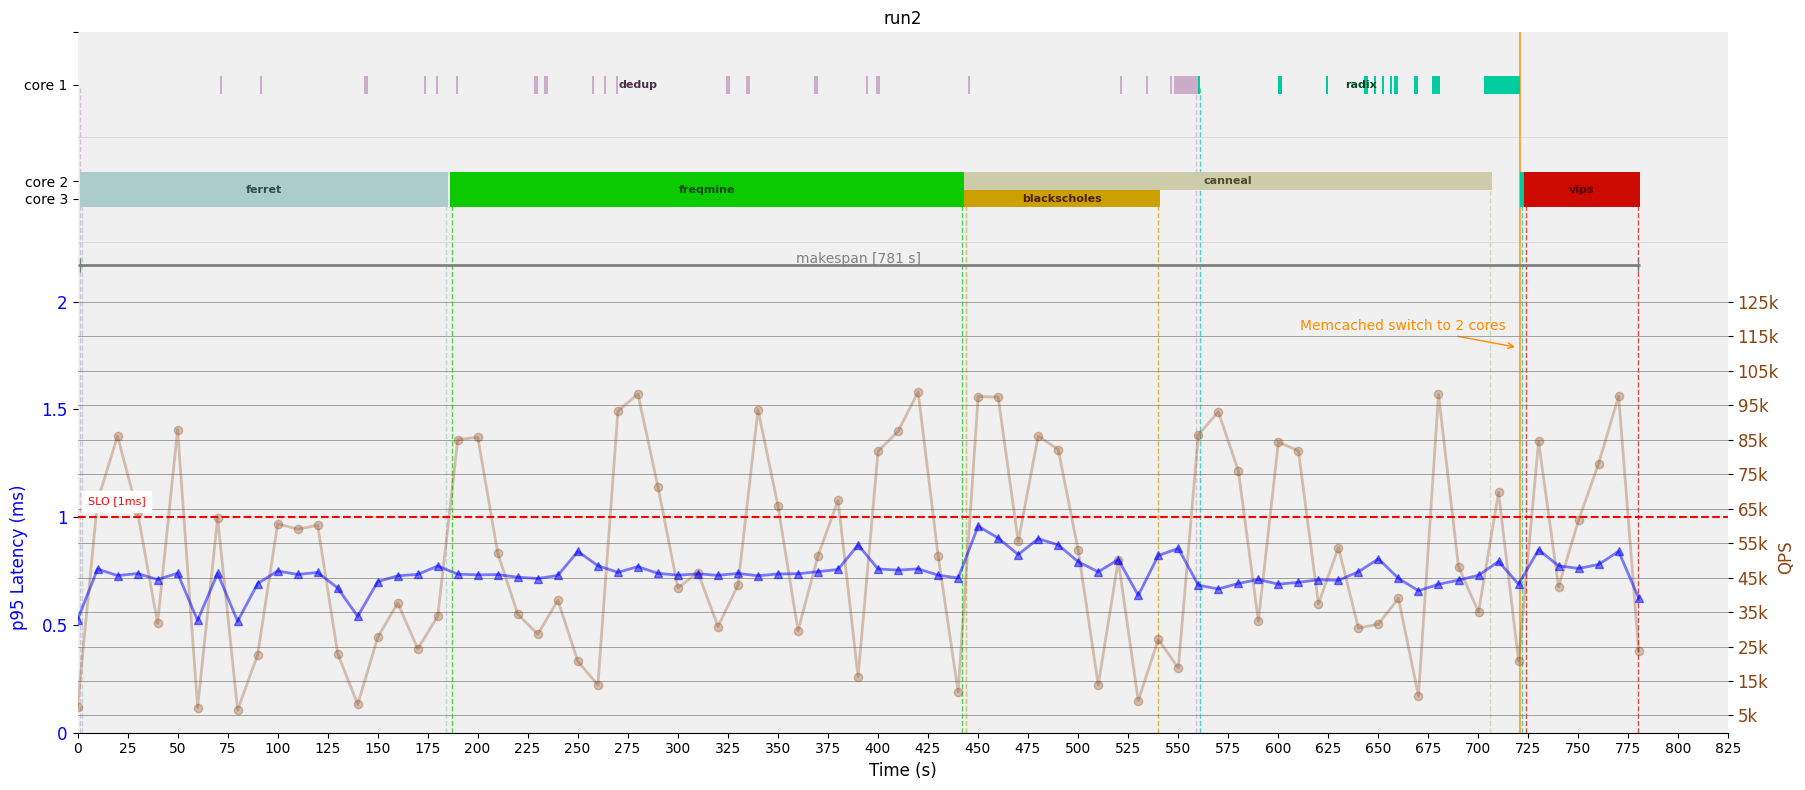

/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_55264/1116199806.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


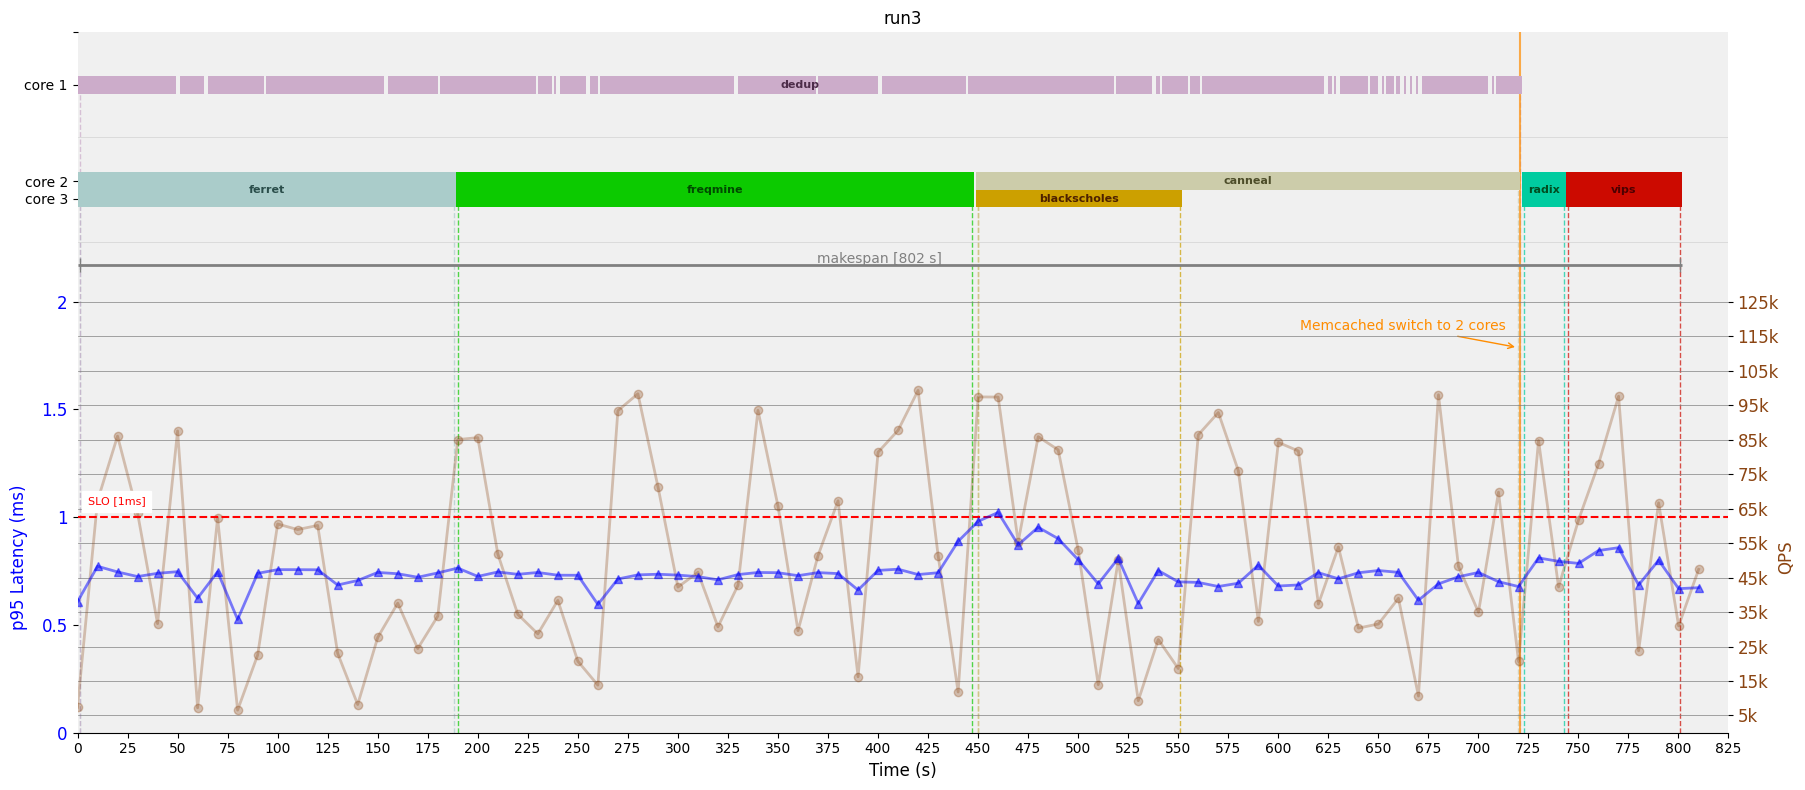

In [77]:
from matplotlib import colors
job_colors = {
    'parsec-blackscholes': '#CCA000',
    'parsec-canneal': '#CCCCAA',
    'parsec-dedup': '#CCACCA',
    'parsec-ferret': '#AACCCA',
    'parsec-freqmine': '#0CCA00',
    'parsec-radix': '#00CCA0',
    'parsec-vips': '#CC0A00'
}
job_lim = {
    'parsec-blackscholes': 0.78,
    'parsec-canneal': 0.78,
    'parsec-dedup': 0.92,
    'parsec-ferret': 0.78,
    'parsec-freqmine': 0.78,
    'parsec-radix': [0.92,0.78],
    'parsec-vips': 0.78,
    'memcached': 'grey'
}
def darken_color(color):
    r, g, b = colors.to_rgb(color)
    new_r = max(0, r - 0.5)
    new_g = max(0, g - 0.5)
    new_b = max(0, b - 0.5)
    darker_color = (new_r, new_g, new_b)
    return darker_color

def plot_combined_plot(mcperf_df, pods_df, run_folder, dist, jobs, total, mem_df):
    fig, ax1 = plt.subplots(figsize=(18, 8))
    ax1.set_facecolor('#F0F0F0') 
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ################################################################
    # step 1 - plot jobs
    ################################################################
    j = jobs.items()
    job_groups = {
        'core 3': ['parsec-ferret', 'parsec-freqmine', 'parsec-blackscholes', 'parsec-canneal'],
        'core 2':[],
        'core 1': ['parsec-dedup','parsec-radix','parsec-vips'],
        '': []
    }
    final_pos = 0
    vertical_spacing = 1.0 
    y_positions = {'core 3': 11.0, 'core 1': 17.0}
    for group_name, group_jobs in job_groups.items():
        for job in group_jobs:
            row = pods_df[pods_df['Job'] == job].iloc[0]
            if row['Job'] in job_colors:
                color = job_colors[row['Job']]
                limit = job_lim[row['Job']]
                j = job[7:]
                if j == 'blackscholes':
                    j = 'black'
                jj = jobs[j]
                if j == 'black':
                    y_positions[group_name] -= 0.5 
                if j== 'canneal':
                    y_positions[group_name] += 1
                if j=='freqmine':
                    final_pos = y_positions[group_name]
                if 'pauses' in jj:
                    pauses = jj['pauses']
                    if j=='radix':
                        for el in pauses:
                            e = pauses[el]
                            s = e[0]
                            f = e[1]
                            if f<switch:
                                ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)
                            if s<switch and f>switch:
                                ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=switch - s, height=1, color=color, zorder=3)
                                ax1.barh(y=final_pos, left=switch, width=f - switch, height=2, color=color, zorder=3)
                            if s>switch and f>switch:
                                ax1.barh(y=final_pos, left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)
                    else:
                        for el in pauses:
                            e = pauses[el]
                            s = e[0]
                            f = e[1]
                            ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)
                else:
                    if j=='vips':
                        y_positions[group_name] = final_pos
                    s = jj['start']
                    f = jj['finish']
                    if j=='black' or j=='canneal':
                        ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)
                    if j=='radix':
                        ax1.barh(y=final_pos, left=s+dist.total_seconds(), width=f - s, height=2, color=color, zorder=3)
                    if j!='black' and j!='canneal' and j!='radix':
                        ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=2, color=color, zorder=3)

                text_x = (jj['start']+dist.total_seconds() + jj['finish']+dist.total_seconds()) / 2  
                text_y = y_positions[group_name]
                if j=='radix' and run_folder == 'run3':
                    ax1.text(text_x, final_pos, job[7:], ha='center', va='center', color=darken_color(color), fontsize=8, fontweight='bold')
                else:
                    ax1.text(text_x, text_y, job[7:], ha='center', va='center', color=darken_color(color), fontsize=8, fontweight='bold')
                if j=='radix':
                    if run_folder == 'run3':
                        ax1.axvline(x=jj['start']+dist.total_seconds()+1, ymin=0,ymax=limit[1],color=color, linestyle='--', alpha=0.7, linewidth=1)
                        ax1.axvline(x=jj['finish']+dist.total_seconds()-1,  ymin=0,ymax=limit[1],color=color, linestyle='--', alpha=0.7, linewidth=1)
                    else:
                        ax1.axvline(x=jj['start']+dist.total_seconds()+1, ymin=0,ymax=limit[0],color=color, linestyle='--', alpha=0.7, linewidth=1)
                        ax1.axvline(x=jj['finish']+dist.total_seconds()-1,  ymin=0,ymax=limit[1],color=color, linestyle='--', alpha=0.7, linewidth=1)
                else:
                    ax1.axvline(x=jj['start']+dist.total_seconds()+1, ymin=0,ymax=limit,color=color, linestyle='--', alpha=0.7, linewidth=1)
                    ax1.axvline(x=jj['finish']+dist.total_seconds()-1,  ymin=0,ymax=limit,color=color, linestyle='--', alpha=0.7, linewidth=1)
        
    ax1.set_ylim(-20)
    ax1.set_yticks([10.5,11.5, 17.0, 20])
    ax1.set_yticklabels(list(job_groups.keys()))
    tray_y_positions = [8, 14.0]
    for y_pos in tray_y_positions:
        ax1.axhline(y=y_pos, color='lightgray', linewidth=0.5)
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_xticks(range(0,850,25))
    ax1.set_xlim(0,825)
    ax1.axvline(x=switch, color='darkorange', alpha=0.7)
    ax1.annotate('Memcached switch to 2 cores', xy=(switch-1, 2), 
             xytext=(switch - 110, 3),
             arrowprops=dict(color='darkorange', arrowstyle='->'), color='darkorange')
    


    ################################################################
    # step 2 - QPS ON RIGHT
    ax2 = ax1.twinx()
    ax2.set_ylim(0, 203.125) 
    ax2.set_yticks(range(5, 135, 10))
    ax2.set_yticklabels([f'{int(x)}k' for x in range(5, 135, 10)], fontsize=12,color='saddlebrown')
    mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()
    ax2.plot(mcperf_df['left'], mcperf_df['QPS']/1000, 'o-', label='95th Percentile Latency (ms)', alpha=0.3, color='saddlebrown', linewidth=2)
    ax2.set_ylabel('QPS', fontsize=12, color='saddlebrown', alpha=1)
    ax2.yaxis.set_label_coords(1.03,0.25)

    ################################################################
    # step 3 - P95 ON LEFT
    ax3 = ax1.twinx()
    ax3.set_ylim(0, 3.25)
    ax3.set_yticks([0, 0.5, 1, 1.5, 2]) 
    ax3.set_yticklabels(['0', '0.5', '1', '1.5', '2'], fontsize=12, color='blue') 
    ax3.set_ylabel('p95 Latency (ms)', fontsize=12, color='blue')
    ax3.yaxis.set_label_position('left')
    ax3.yaxis.set_label_coords(-0.030,0.25)
    ax3.yaxis.tick_left()
    ax3.axhline(y=1, color='red', linestyle='--', label='1 ms')
    ax3.text(5, 1.05, 'SLO [1ms]', color='red', fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', edgecolor='white', alpha=1))
    ax3.plot(mcperf_df['left'], mcperf_df['p95'], '^-',label='95th Percentile Latency (ms)', alpha=0.5, color='blue', linewidth=2)
    
    maxt=total[1]
    ax3.hlines(y=2.17, xmin=dist.total_seconds(), xmax=maxt, color='gray', linewidth=2 )
    ax3.text((dist.total_seconds() + maxt) / 2, 2.20, f'makespan [{int(maxt)} s]', horizontalalignment='center', verticalalignment='center', color='gray')
    ax3.plot(dist.total_seconds()+1, 2.17, marker='|', markersize=10, color='gray')
    ax3.plot(maxt-1, 2.17, marker='|', markersize=10, color='gray')

    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # Add horizontal grid lines only on the right side
    ax2.grid(axis='y', which='major', color='grey', linewidth=0.5)

    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    plt.title(run_folder)
    plt.tight_layout()
    plt.show()
for i, run_folder in enumerate(['run1', 'run2', 'run3']):
    plot_combined_plot(all_mcperf_data2[i], all_pods_data[i], run_folder, distances[i], total_jobs[i],total[i], total_mem_to[i])


### plot B

0.0


/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_55264/3303430059.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


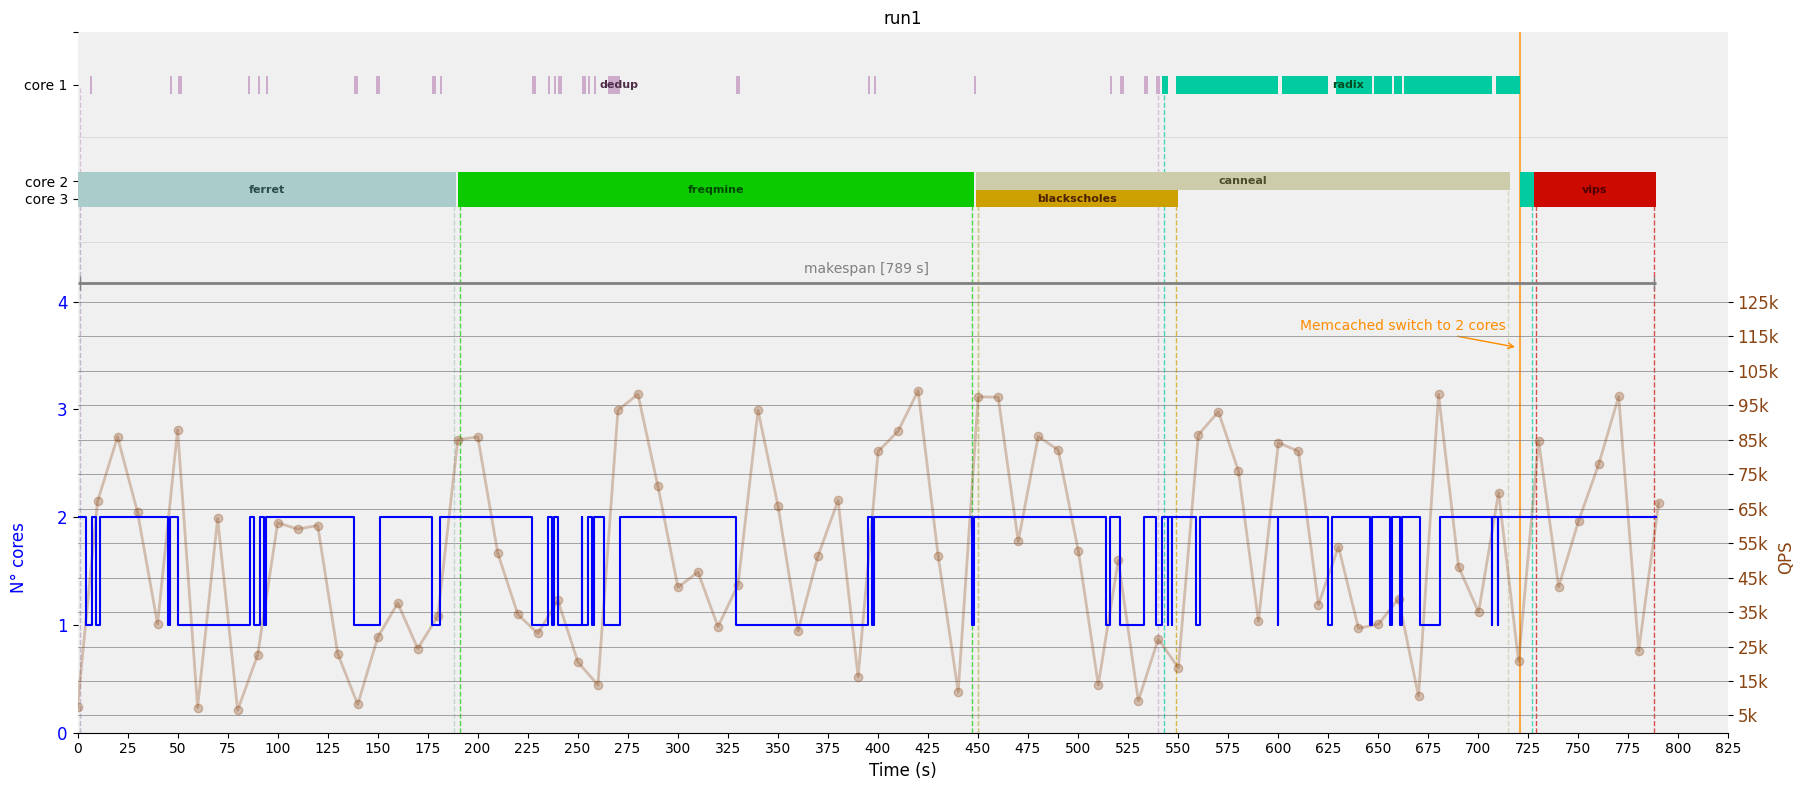

0.0


/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_55264/3303430059.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


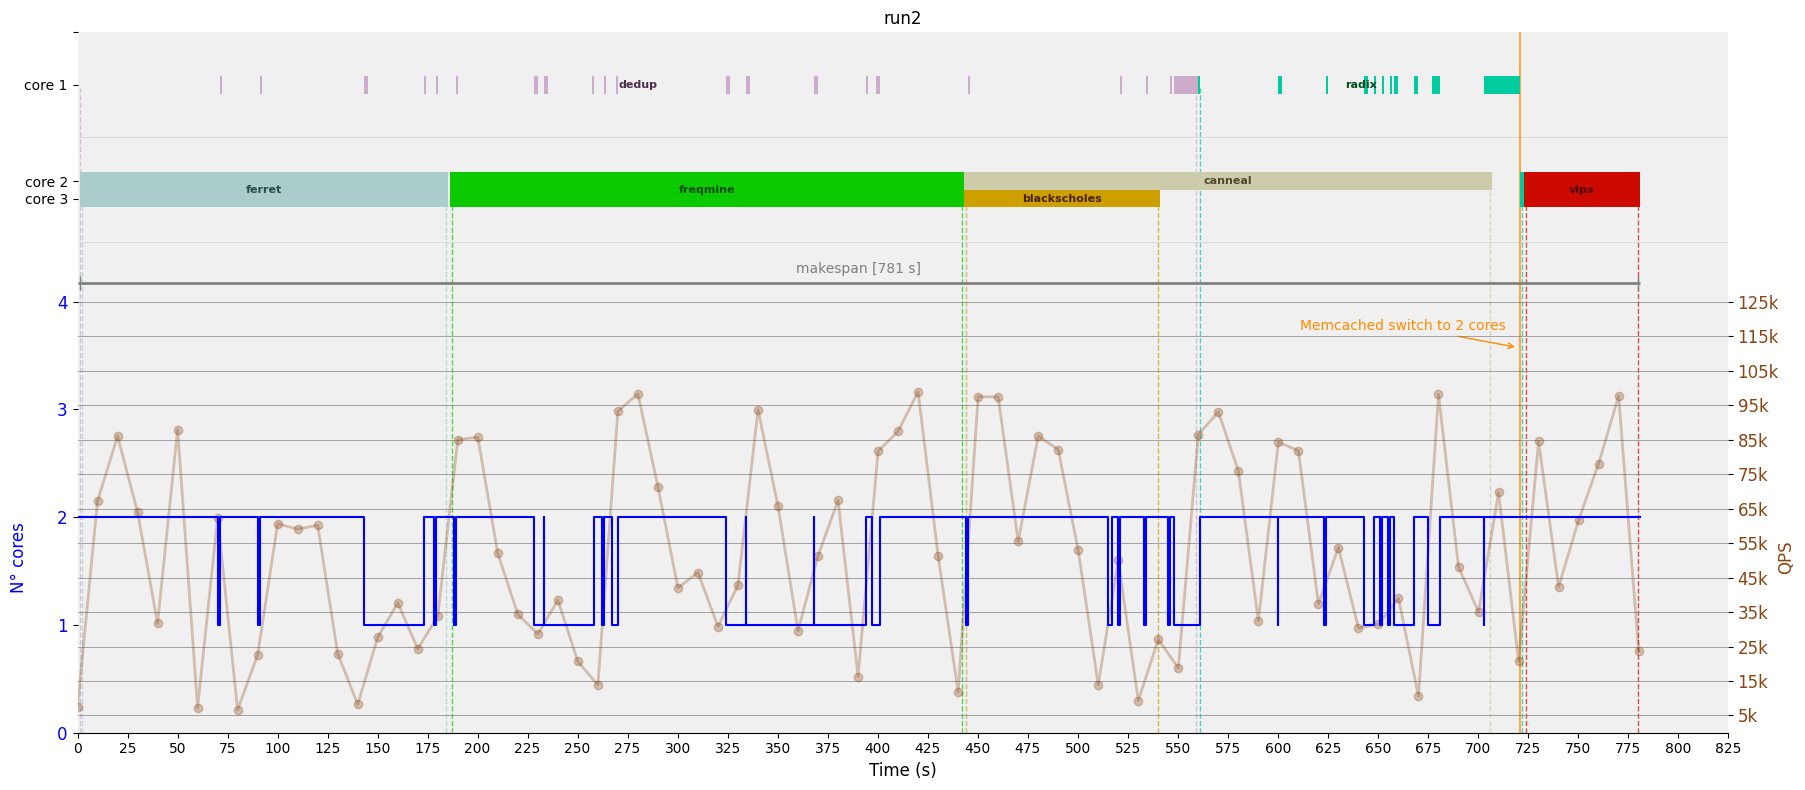

0.0


/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_55264/3303430059.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


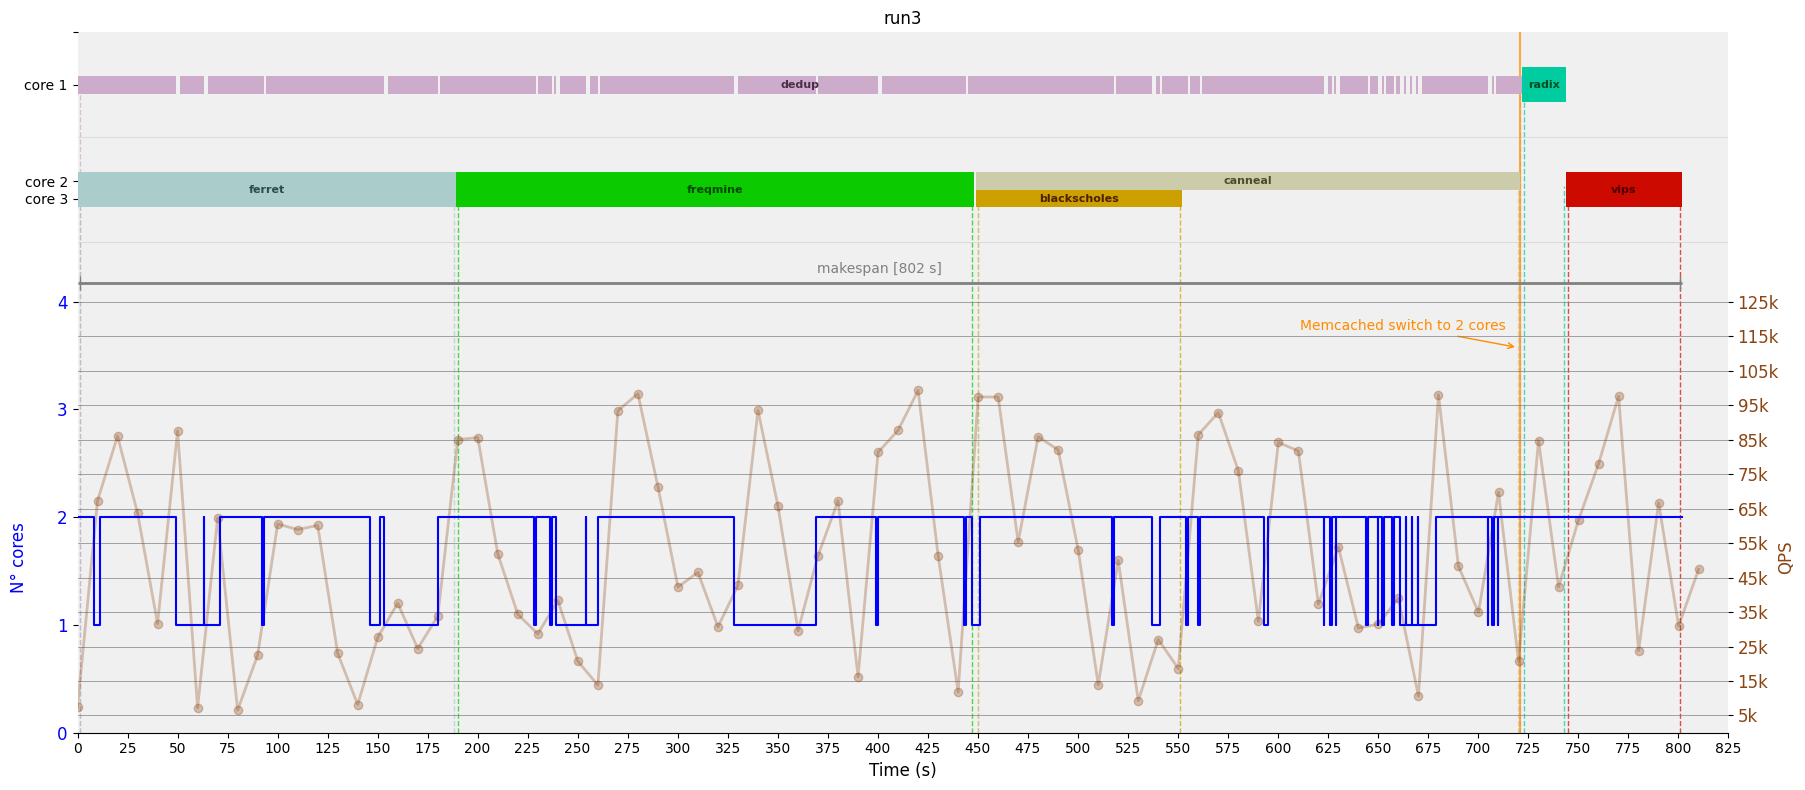

In [78]:
job_colors = {
    'parsec-blackscholes': '#CCA000',
    'parsec-canneal': '#CCCCAA',
    'parsec-dedup': '#CCACCA',
    'parsec-ferret': '#AACCCA',
    'parsec-freqmine': '#0CCA00',
    'parsec-radix': '#00CCA0',
    'parsec-vips': '#CC0A00'
}
job_lim = {
    'parsec-blackscholes': 0.78,
    'parsec-canneal': 0.78,
    'parsec-dedup': 0.92,
    'parsec-ferret': 0.78,
    'parsec-freqmine': 0.78,
    'parsec-radix': [0.92,0.78],
    'parsec-vips': 0.78,
    'memcached': 'grey'
}
def darken_color(color):
    r, g, b = colors.to_rgb(color)
    new_r = max(0, r - 0.5)
    new_g = max(0, g - 0.5)
    new_b = max(0, b - 0.5)
    darker_color = (new_r, new_g, new_b)
    return darker_color

def plot_combined_plot(mcperf_df, pods_df, run_folder, dist, jobs, total, mem_df):
    general_s = total[0]
    print(general_s)
    fig, ax1 = plt.subplots(figsize=(18, 8))
    ax1.set_facecolor('#F0F0F0') 
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ################################################################
    # step 1 - plot jobs
    ################################################################
    j = jobs.items()
    job_groups = {
        'core 3': ['parsec-ferret', 'parsec-freqmine', 'parsec-blackscholes', 'parsec-canneal'],
        'core 2':[],
        'core 1': ['parsec-dedup','parsec-radix','parsec-vips'],
        '': []
    }
    final_pos = 0
    vertical_spacing = 1.0 
    y_positions = {'core 3': 11.0, 'core 1': 17.0}
    for group_name, group_jobs in job_groups.items():
        for job in group_jobs:
            row = pods_df[pods_df['Job'] == job].iloc[0]
            if row['Job'] in job_colors:
                color = job_colors[row['Job']]
                limit = job_lim[row['Job']]
                j = job[7:]
                if j == 'blackscholes':
                    j = 'black'
                jj = jobs[j]
                if j == 'black':
                    y_positions[group_name] -= 0.5 
                if j== 'canneal':
                    y_positions[group_name] += 1
                if j=='freqmine':
                    final_pos = y_positions[group_name]
                if 'pauses' in jj:
                    pauses = jj['pauses']
                    if j=='radix':
                        for el in pauses:
                            e = pauses[el]
                            s = e[0]
                            f = e[1]
                            if f<switch:
                                ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)
                            if s<switch and f>switch:
                                ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=switch - s, height=1, color=color, zorder=3)
                                ax1.barh(y=final_pos, left=switch, width=f - switch, height=2, color=color, zorder=3)
                            if s>switch and f>switch:
                                ax1.barh(y=final_pos, left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)
                    else:
                        for el in pauses:
                            e = pauses[el]
                            s = e[0]
                            f = e[1]
                            ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)
                else:
                    if j=='vips':
                        y_positions[group_name] = final_pos
                    s = jj['start']
                    f = jj['finish']
                    if j=='black' or j=='canneal':
                        ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)
                    else:
                        ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=2, color=color, zorder=3)

                text_x = (jj['start']+dist.total_seconds() + jj['finish']+dist.total_seconds()) / 2  
                text_y = y_positions[group_name]
                ax1.text(text_x, text_y, job[7:], ha='center', va='center', color=darken_color(color), fontsize=8, fontweight='bold')
                if j=='radix':
                    ax1.axvline(x=jj['start']+dist.total_seconds()+1, ymin=0,ymax=limit[0],color=color, linestyle='--', alpha=0.7, linewidth=1)
                    ax1.axvline(x=jj['finish']+dist.total_seconds()-1,  ymin=0,ymax=limit[1],color=color, linestyle='--', alpha=0.7, linewidth=1)
                else:
                    ax1.axvline(x=jj['start']+dist.total_seconds()+1, ymin=0,ymax=limit,color=color, linestyle='--', alpha=0.7, linewidth=1)
                    ax1.axvline(x=jj['finish']+dist.total_seconds()-1,  ymin=0,ymax=limit,color=color, linestyle='--', alpha=0.7, linewidth=1)
        
    ax1.set_ylim(-20)
    ax1.set_yticks([10.5,11.5, 17.0, 20])
    ax1.set_yticklabels(list(job_groups.keys()))
    tray_y_positions = [8, 14.0]
    for y_pos in tray_y_positions:
        ax1.axhline(y=y_pos, color='lightgray', linewidth=0.5)
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_xticks(range(0,850,25))
    ax1.set_xlim(0,825)
    ax1.axvline(x=switch, color='darkorange', alpha=0.7)
    ax1.annotate('Memcached switch to 2 cores', xy=(switch-1, 2), 
             xytext=(switch - 110, 3),
             arrowprops=dict(color='darkorange', arrowstyle='->'), color='darkorange')

    ################################################################
    # step 2 - QPS ON RIGHT
    ax2 = ax1.twinx()
    ax2.set_ylim(0, 203.125) 
    ax2.set_yticks(range(5, 135, 10))
    ax2.set_yticklabels([f'{int(x)}k' for x in range(5, 135, 10)], fontsize=12,color='saddlebrown')
    mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()
    ax2.plot(mcperf_df['left'], mcperf_df['QPS']/1000, 'o-', label='95th Percentile Latency (ms)', alpha=0.3, color='saddlebrown', linewidth=2)
    ax2.set_ylabel('QPS', fontsize=12, color='saddlebrown', alpha=1)
    ax2.yaxis.set_label_coords(1.03,0.25)

    ################################################################
    # step 3 - P95 ON LEFT
    ax3 = ax1.twinx()
    ax3.set_ylim(0, 6.5)
    ax3.set_yticks([0, 1, 2, 3, 4]) 
    ax3.set_yticklabels(['0', '1', '2', '3', '4'], fontsize=12, color='blue') 
    ax3.set_ylabel('N° cores', fontsize=12, color='blue')
    ax3.yaxis.set_label_position('left')
    ax3.yaxis.set_label_coords(-0.030,0.25)
    ax3.yaxis.tick_left()
    mem_df['plot'] = mem_df['timestamp']
    extended_values = {'plot': [total[1]], 'value': [2]}
    extended_df = pd.DataFrame(extended_values)
    mem_df_extended = pd.concat([mem_df, extended_df], ignore_index=True)
    ax3.step(mem_df_extended['plot'], mem_df_extended['value'], where='post', color='blue')

    maxt=total[1]
    ax3.hlines(y=4.17, xmin=dist.total_seconds(), xmax=maxt, color='gray', linewidth=2)
    ax3.text((dist.total_seconds() + maxt) / 2, 4.30, f'makespan [{int(maxt)} s]', horizontalalignment='center', verticalalignment='center', color='gray')
    ax3.plot(dist.total_seconds()+1, 4.17, marker='|', markersize=10, color='gray')
    ax3.plot(maxt-1, 4.17, marker='|', markersize=10, color='gray')

    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # Add horizontal grid lines only on the right side
    ax2.grid(axis='y', which='major', color='grey', linewidth=0.5)

    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    plt.title(run_folder)
    plt.tight_layout()
    plt.show()
for i, run_folder in enumerate(['run1', 'run2', 'run3']):
    plot_combined_plot(all_mcperf_data2[i], all_pods_data[i], run_folder, distances[i], total_jobs[i],total[i], total_mem_to[i])


## 3) DYNAMIC SCHEDULING WITH 5MS INTERVALS

#### 3.1 - PREPROCESSING

##### 3.1.1 - job preprocessing

In [99]:
# step 1 - jobs preprocessing

# utility functions
def subtract_2_hours(timestamp):
    # what: subtract 2 hours from timestamp
    # why: noticed that mcperf and pods timestamps are off by 2 hours -> solution subtract 2 hours
    return timestamp - timedelta(hours=2)

def merge_start_finish_times(start_times, finish_times,job, s, e, general,st, run):
    # from raw data: start, finish, start pause, end pause -> extract timestamps where job is running
    job['pauses']={}
    start_index = 0
    finish_index = 0
    i = -1
    if len(finish_times)> len(start_times):
        start_times.insert(0, st)
    if len(start_times)> len(finish_times):
        start_times=start_times[:-1]
    while start_index <= len(start_times) and finish_index <= len(finish_times):
        i += 1
        finish_time = finish_times[finish_index]
        if start_index == len(start_times):
            f = finish_time - general
            f = f.total_seconds()
            job['pauses'][i] = (f, e)
            break
        start_time = start_times[start_index]

        if start_index == 0:
            staart = start_time - general
            staart = staart.total_seconds()
            job['pauses'][i] = (s, staart)
        if start_index != 0 and start_index != len(start_times):
            f = finish_time - general
            f = f.total_seconds()
            staart = start_time - general
            staart = staart.total_seconds()
            if run=='1':
                job['pauses'][i] = (f+2, staart)
            else: 
                job['pauses'][i] = (f+2, staart)
            finish_index += 1
        start_index += 1
    return job['pauses']

def job_preprocessing(run):
    path = './data4/scheduling/43/'+run+'/times_1.json'
    with open(path) as file:
        data = json.load(file)
    total=[]
    jobs = {}
    mem_to_1 = []
    mem_to_2 = []
    switch = 0
    total_t = []
    for job_name, job_data in data.items():
        if job_name == 'total':
            # total is the total makespan
            # start of first job
            start = datetime.fromtimestamp(float(job_data['start'])).replace(microsecond=0)
            start = subtract_2_hours(start)
            total_t.append(start)
            general_s= start
            start = start - general_s
            start = start.total_seconds()
            # end of all jobs
            end = datetime.fromtimestamp(float(job_data['finish'])).replace(microsecond=0)
            end = subtract_2_hours(end)
            total_t.append(end)
            end = end - general_s
            end = end.total_seconds()
            total.append(start)
            total.append(end)

        if job_name != 'total' and job_name != 'mem' and job_name != 'cpu' and job_name != 'pauses' and job_name != 'switch_job_1':
            if job_name == 'vips':
                # vips has the problem that it is the last job to end so the end is the same as total end
                # start from the file
                start = datetime.fromtimestamp(float(job_data['start'])).replace(microsecond=0)
                start = subtract_2_hours(start)
                start = start - general_s
                start = start.total_seconds()
                # fix end as total end
                job = {
                'start': start,
                'finish': total[1]
                }
            else:
                # start from the file
                start = datetime.fromtimestamp(float(job_data['start'])).replace(microsecond=0)
                start_t = subtract_2_hours(start)
                start = start_t - general_s
                start = start.total_seconds()
                # end from the file
                end = datetime.fromtimestamp(float(job_data['finish'])).replace(microsecond=0)
                end_t = subtract_2_hours(end)
                end = end_t - general_s
                end = end.total_seconds()
                job = {
                'start': start,
                'finish': end
                }
                if 'pauses' in job_data:
                    f = True
                    pauses = job_data['pauses']
                    if 'pause' in pauses:
                        if pauses['pause'] ==[]:
                            f = False
                        pauses_a = [ datetime.fromtimestamp(float(pause)).replace(microsecond=0) for pause in pauses['pause']]
                        pausess = [ subtract_2_hours(p) for p in pauses_a]
                    if 'unpause' in pauses:
                        if pauses['unpause'] ==[]:
                            f = False
                        unpauses_a = [ datetime.fromtimestamp(float(unpause)).replace(microsecond=0) for unpause in pauses['unpause']]
                        unpausess = [ subtract_2_hours(p) for p in unpauses_a]
                    # this computes the job intervals when the job is running
                    if f:
                        job['pauses'] = merge_start_finish_times(pausess, unpausess, job, start, end, general_s, start_t, run)
            jobs[job_name] = job
        if job_name == 'mem':
            one = job_data['to_1']
            one_a = [ datetime.fromtimestamp(float(o)).replace(microsecond=0) for o in one]
            mem_to_1 = [ (subtract_2_hours(o)- general_s).total_seconds() for o in one_a]
            two = job_data['to_2']
            two_a = [ datetime.fromtimestamp(float(t)).replace(microsecond=0) for t in two]
            mem_to_2 = [ (subtract_2_hours(t)- general_s).total_seconds() for t in two_a]
        if job_name == 'switch_job_1':
            t = datetime.fromtimestamp(float(job_data)).replace(microsecond=0)
            t = subtract_2_hours(t)
            t = t - general_s
            t = t.total_seconds()
            switch = t
    return mem_to_1,mem_to_2, switch,jobs, total, total_t

total_jobs=[]
total_mem_to = []
total_switch=[]
total=[]
total_t=[]
for i, run in enumerate(['1','2','3']):
    mem_to_1,mem_to_2, switch,jobs, totali, total_ti = job_preprocessing(run)
    total_jobs.append(jobs)
    print("Job Information:")
    for job_name, job in jobs.items():
        print(f"{job_name}:")
        print(f"Start Time: {job['start']}")
        print(f"Finish Time: {job['finish']}")
        if 'pauses' in job:
            print("Pauses:")
            for pause_time in job['pauses']:
                print(f"  {pause_time}:", job['pauses'][pause_time])

    mem_df = pd.DataFrame({'timestamp': mem_to_1 + mem_to_2, 'value': [1] * len(mem_to_1) + [2] * len(mem_to_2)})
    mem_df.sort_values(by='timestamp', inplace=True)
    print(mem_df)
    total_mem_to.append(mem_df)
    total_switch.append(switch)
    total.append(totali)
    total_t.append(total_ti)
    print('--------------------------------', total)

Job Information:
black:
Start Time: 439.0
Finish Time: 540.0
canneal:
Start Time: 439.0
Finish Time: 664.0
dedup:
Start Time: 0.0
Finish Time: 639.0
Pauses:
  0: (0.0, 0.0)
  1: (9.0, 7.0)
  2: (11.0, 9.0)
  3: (16.0, 14.0)
  4: (20.0, 19.0)
  5: (26.0, 24.0)
  6: (48.0, 46.0)
  7: (50.0, 49.0)
  8: (62.0, 61.0)
  9: (65.0, 64.0)
  10: (153.0, 151.0)
  11: (190.0, 189.0)
  12: (200.0, 200.0)
  13: (207.0, 207.0)
  14: (229.0, 227.0)
  15: (258.0, 256.0)
  16: (283.0, 281.0)
  17: (295.0, 294.0)
  18: (325.0, 323.0)
  19: (333.0, 331.0)
  20: (336.0, 334.0)
  21: (350.0, 349.0)
  22: (360.0, 359.0)
  23: (377.0, 375.0)
  24: (413.0, 411.0)
  25: (420.0, 418.0)
  26: (430.0, 429.0)
  27: (463.0, 461.0)
  28: (480.0, 479.0)
  29: (498.0, 496.0)
  30: (528.0, 529.0)
  31: (573.0, 572.0)
  32: (585.0, 584.0)
  33: (609.0, 607.0)
  34: (613.0, 619.0)
  35: (633.0, 632.0)
  36: (634.0, 639.0)
ferret:
Start Time: 1.0
Finish Time: 197.0
freqmine:
Start Time: 198.0
Finish Time: 439.0
radix:
Star

##### 3.1.2 - mcperf preprocessing

In [100]:
# step 2 - mcperf preprocessing
# utitity functions
def subtract_2_hours(timestamp):
    # what: subtract 2 hours from timestamp
    # why: noticed that mcperf and pods timestamps are off by 2 hours -> solution subtract 2 hours
    return timestamp - timedelta(hours=2)

def read_mcperf_data(folder):
    # what: preprocessing of mcperf data
    mcperf_path = os.path.join('data4/scheduling/43', folder, 'mem.txt')
    with open(mcperf_path, 'r') as file:
        start_timestamp = int(file.readline().split(': ')[1])
        end_timestamp = int(file.readline().split(': ')[1])
    
    df = pd.read_csv(mcperf_path, skiprows=2, sep='\s+')
    total_seconds = (end_timestamp - start_timestamp) / 1000
    num_rows = len(df)
    interval_seconds = total_seconds / num_rows
    df['ts_start'] = start_timestamp / 1000
    df['ts_end'] = df['ts_start'] + interval_seconds

    # Update ts_start and ts_end for each row
    for i in range(1, num_rows):
        df.at[i, 'ts_start'] = df.at[i-1, 'ts_end']
        df.at[i, 'ts_end'] = df.at[i, 'ts_start'] + interval_seconds
    # all in seconds
    df['p95'] = df['p95'] / 1000

    # have a timestamp for both start and end (needed for synchronization)
    df['start_timestamp'] = df['ts_start'].apply(lambda x: datetime.fromtimestamp(x).replace(microsecond=0))
    df['end_timestamp'] = df['ts_end'].apply(lambda x: datetime.fromtimestamp(x).replace(microsecond=0))
    df['start_timestamp'] = df['start_timestamp'].apply(subtract_2_hours)
    df['end_timestamp'] = df['end_timestamp'].apply(subtract_2_hours)
    return df



def cut_df(mcperf,total):
    # this function cuts off the parts of the mcperf file(/df) that are not neeeded because they are not relative to the makespan of the jobs
    # notice that first the times are synchronized

    # step 1 - identify the interval of interest
    # min start time of all jobs
    min_time = total[0]
    # max end time of all jobs
    max_time = total[1]

    # step 2 - pick indices of mcperf intervall in which the min start time takes place
    # condition: min start time is greater than the start interval and smaller than the end interval
    indici_pre_min = mcperf.loc[mcperf['start_timestamp'] <= min_time].index
    indici_post_min = mcperf.loc[mcperf['end_timestamp']>=min_time].index
    common_min_indices = set(indici_pre_min).intersection(indici_post_min)
    first_common_min_index = min(common_min_indices)
    
    # step 3 - pick indices of mcperf intervall in which the max end time takes place
    # condition: max end time is greater than the start interval and smaller than the end interval
    indici_pre_max = mcperf.loc[mcperf['start_timestamp'] <= max_time].index
    indici_post_max = mcperf.loc[mcperf['end_timestamp']>=max_time].index
    common_max_indices = set(indici_pre_max).intersection(indici_post_max)
    first_common_max_index = min(common_max_indices)

    # step 4 - we have the first index to consider and the last one, we slice the df accordingly
    sliced_df = mcperf.iloc[first_common_min_index:first_common_max_index + 2]
    dist =  min_time - mcperf.iloc[first_common_min_index]['start_timestamp']
    return sliced_df, dist

# thic contains mcperf data WITHOUT syncrhonization
all_mcperf_data = []
# this contains mcperf data WITH synchronization
all_mcperf_data2=[]
# this contains the distance betweeen the min start of the pod and the start of the mcperf interval
distances =[]

for i, run in enumerate(['1','2','3']):
    mcperf = read_mcperf_data(run)
    all_mcperf_data.append(mcperf)
    sliced_df, dist = cut_df(mcperf,total_t[i])
    all_mcperf_data2.append(sliced_df)
    distances.append(dist)

    # step 4 - count SLO violations
    violation_count = (mcperf['p95'] > 1).sum()
    total_data_points = len(mcperf)
    slo_violation_ratio = violation_count / total_data_points
    print("SLO violation ratio:", slo_violation_ratio)

SLO violation ratio: 0.00909090909090909
SLO violation ratio: 0.004545454545454545
SLO violation ratio: 0.017777777777777778


#### 3.2 - PLOT

### plot A

/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_55264/2481553529.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


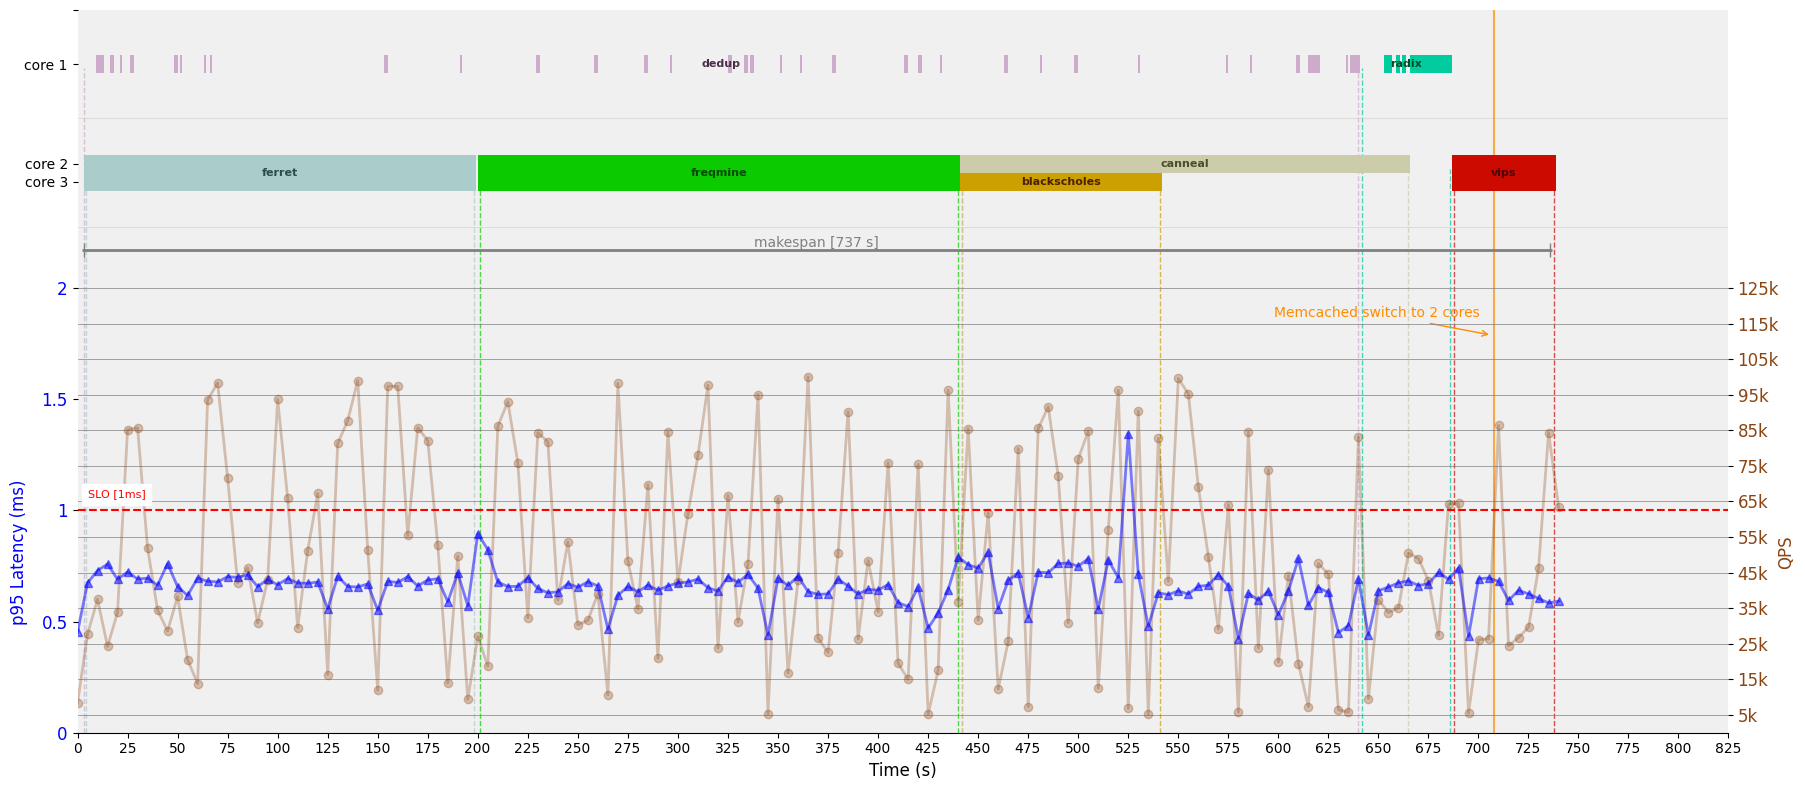

/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_55264/2481553529.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


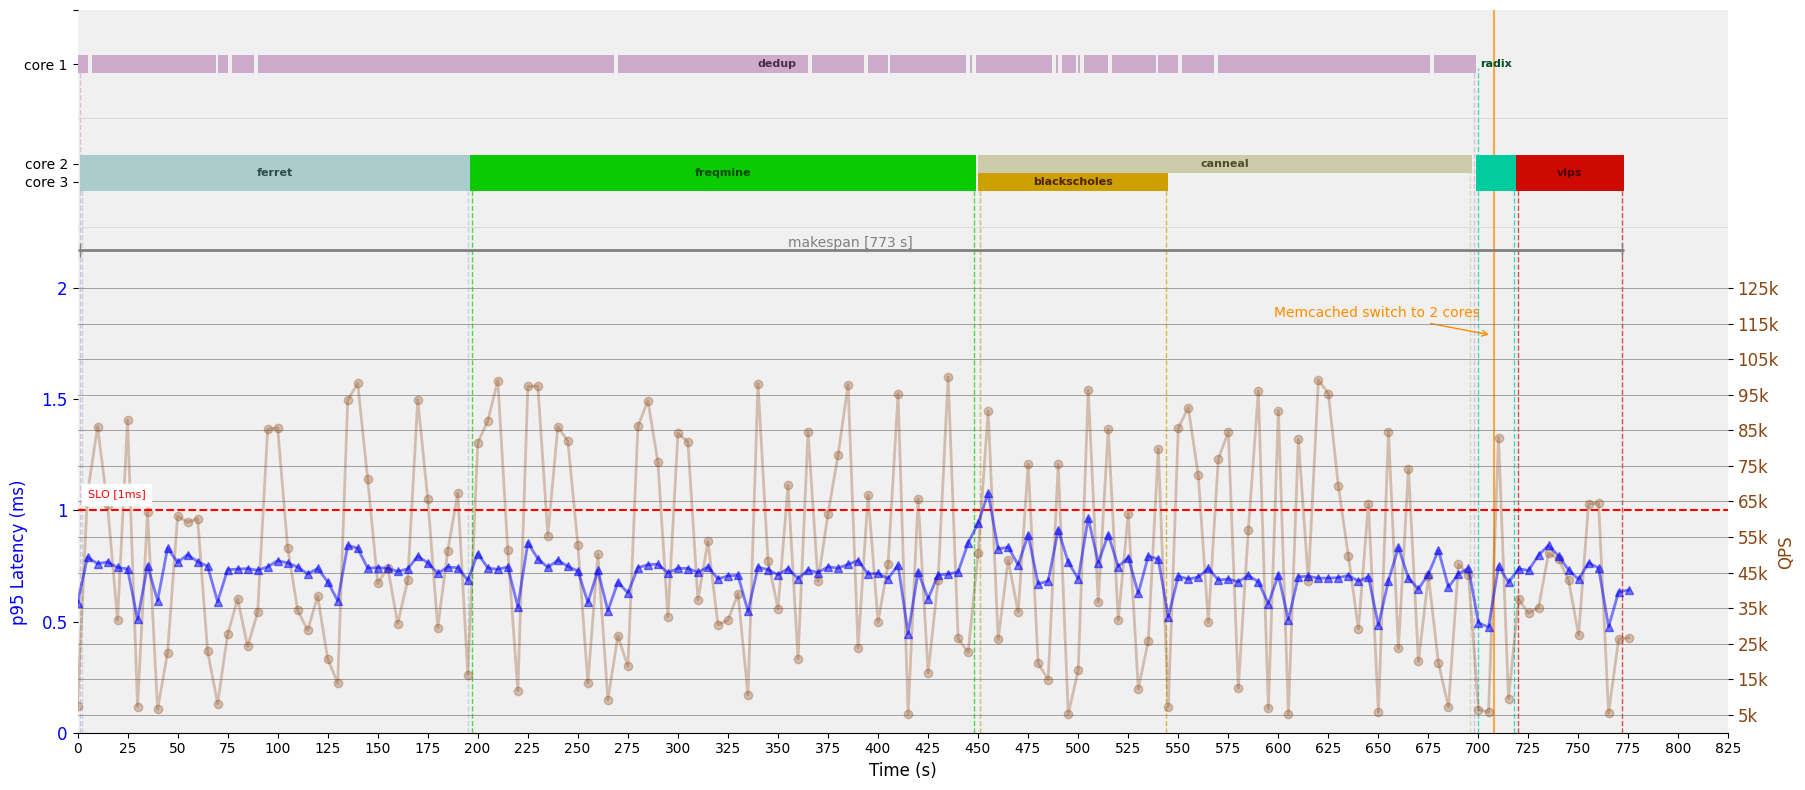

/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_55264/2481553529.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


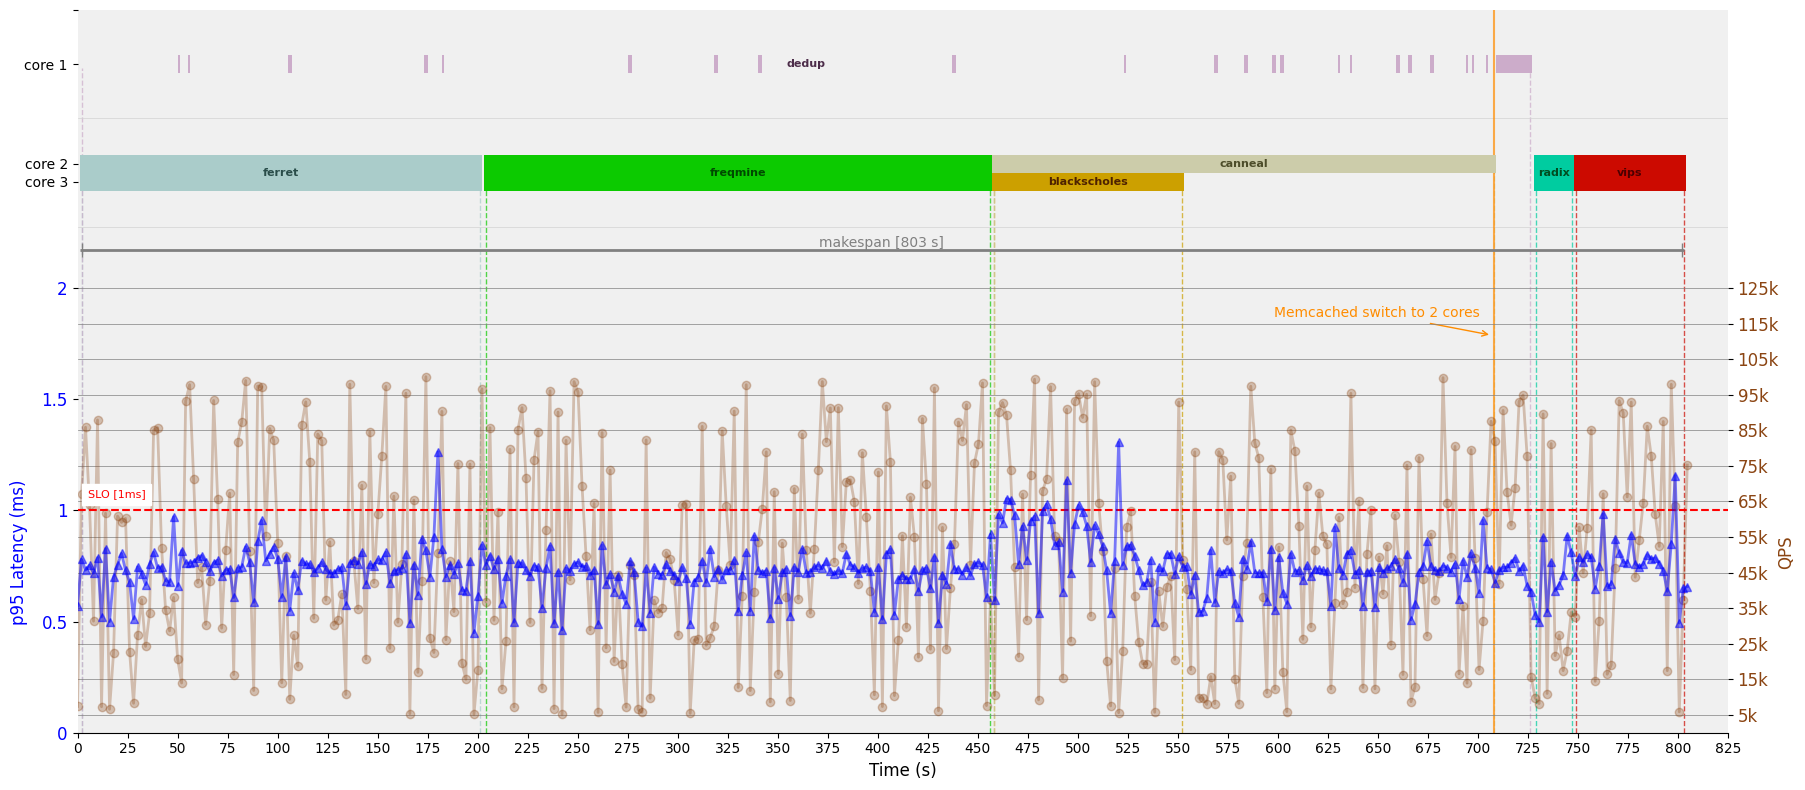

In [101]:
job_colors = {
    'parsec-blackscholes': '#CCA000',
    'parsec-canneal': '#CCCCAA',
    'parsec-dedup': '#CCACCA',
    'parsec-ferret': '#AACCCA',
    'parsec-freqmine': '#0CCA00',
    'parsec-radix': '#00CCA0',
    'parsec-vips': '#CC0A00'
}
job_lim = {
    'parsec-blackscholes': 0.78,
    'parsec-canneal': 0.78,
    'parsec-dedup': 0.92,
    'parsec-ferret': 0.78,
    'parsec-freqmine': 0.78,
    'parsec-radix': [0.92,0.78],
    'parsec-vips': 0.78,
    'memcached': 'grey'
}
def darken_color(color):
    r, g, b = colors.to_rgb(color)
    new_r = max(0, r - 0.5)
    new_g = max(0, g - 0.5)
    new_b = max(0, b - 0.5)
    darker_color = (new_r, new_g, new_b)
    return darker_color

def plot_combined_plot(mcperf_df, pods_df, run_folder, dist, jobs, total, mem_df):
    fig, ax1 = plt.subplots(figsize=(18, 8))
    ax1.set_facecolor('#F0F0F0') 
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ################################################################
    # step 1 - plot jobs
    ################################################################
    j = jobs.items()
    job_groups = {
        'core 3': ['parsec-ferret', 'parsec-freqmine', 'parsec-blackscholes', 'parsec-canneal'],
        'core 2':[],
        'core 1': ['parsec-dedup','parsec-radix','parsec-vips'],
        '': []
    }
    final_pos = 0
    vertical_spacing = 1.0 
    y_positions = {'core 3': 11.0, 'core 1': 17.0}
    for group_name, group_jobs in job_groups.items():
        for job in group_jobs:
            row = pods_df[pods_df['Job'] == job].iloc[0]
            if row['Job'] in job_colors:
                color = job_colors[row['Job']]
                limit = job_lim[row['Job']]
                j = job[7:]
                if j == 'blackscholes':
                    j = 'black'
                jj = jobs[j]
                if j == 'black':
                    y_positions[group_name] -= 0.5 
                if j== 'canneal':
                    y_positions[group_name] += 1
                if j=='freqmine':
                    final_pos = y_positions[group_name]
                if 'pauses' in jj:
                    pauses = jj['pauses']
                    if j=='radix':
                        for el in pauses:
                            e = pauses[el]
                            s = e[0]
                            f = e[1]
                            if f<switch:
                                ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)
                            if s<switch and f>switch:
                                ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=switch - s, height=1, color=color, zorder=3)
                                ax1.barh(y=final_pos, left=switch, width=f - switch, height=2, color=color, zorder=3)
                            if s>switch and f>switch:
                                ax1.barh(y=final_pos, left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)
                    else:
                        for el in pauses:
                            e = pauses[el]
                            s = e[0]
                            f = e[1]
                            ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)
                else:
                    if j=='vips':
                        y_positions[group_name] = final_pos
                    s = jj['start']
                    f = jj['finish']
                    if j=='black' or j=='canneal':
                        ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)
                    if j=='radix':
                        ax1.barh(y=final_pos, left=s+dist.total_seconds(), width=f - s, height=2, color=color, zorder=3)
                    if j!='black' and j!='canneal' and j!='radix':
                        ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=2, color=color, zorder=3)

                text_x = (jj['start']+dist.total_seconds() + jj['finish']+dist.total_seconds()) / 2  
                text_y = y_positions[group_name]
                if j=='radix' and run_folder == 'run3':
                    ax1.text(text_x, final_pos, job[7:], ha='center', va='center', color=darken_color(color), fontsize=8, fontweight='bold')
                else:
                    ax1.text(text_x, text_y, job[7:], ha='center', va='center', color=darken_color(color), fontsize=8, fontweight='bold')
                if j=='radix':
                    if run_folder == 'run3':
                        ax1.axvline(x=jj['start']+dist.total_seconds()+1, ymin=0,ymax=limit[1],color=color, linestyle='--', alpha=0.7, linewidth=1)
                        ax1.axvline(x=jj['finish']+dist.total_seconds()-1,  ymin=0,ymax=limit[1],color=color, linestyle='--', alpha=0.7, linewidth=1)
                    else:
                        ax1.axvline(x=jj['start']+dist.total_seconds()+1, ymin=0,ymax=limit[0],color=color, linestyle='--', alpha=0.7, linewidth=1)
                        ax1.axvline(x=jj['finish']+dist.total_seconds()-1,  ymin=0,ymax=limit[1],color=color, linestyle='--', alpha=0.7, linewidth=1)
                else:
                    ax1.axvline(x=jj['start']+dist.total_seconds()+1, ymin=0,ymax=limit,color=color, linestyle='--', alpha=0.7, linewidth=1)
                    ax1.axvline(x=jj['finish']+dist.total_seconds()-1,  ymin=0,ymax=limit,color=color, linestyle='--', alpha=0.7, linewidth=1)
        
    ax1.set_ylim(-20)
    ax1.set_yticks([10.5,11.5, 17.0, 20])
    ax1.set_yticklabels(list(job_groups.keys()))
    tray_y_positions = [8, 14.0]
    for y_pos in tray_y_positions:
        ax1.axhline(y=y_pos, color='lightgray', linewidth=0.5)
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_xticks(range(0,850,25))
    ax1.set_xlim(0,825)
    ax1.axvline(x=switch, color='darkorange', alpha=0.7)
    ax1.annotate('Memcached switch to 2 cores', xy=(switch-1, 2), 
             xytext=(switch - 110, 3),
             arrowprops=dict(color='darkorange', arrowstyle='->'), color='darkorange')
    


    ################################################################
    # step 2 - QPS ON RIGHT
    ax2 = ax1.twinx()
    ax2.set_ylim(0, 203.125) 
    ax2.set_yticks(range(5, 135, 10))
    ax2.set_yticklabels([f'{int(x)}k' for x in range(5, 135, 10)], fontsize=12,color='saddlebrown')
    mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()
    ax2.plot(mcperf_df['left'], mcperf_df['QPS']/1000, 'o-', label='95th Percentile Latency (ms)', alpha=0.3, color='saddlebrown', linewidth=2)
    ax2.set_ylabel('QPS', fontsize=12, color='saddlebrown', alpha=1)
    ax2.yaxis.set_label_coords(1.03,0.25)

    ################################################################
    # step 3 - P95 ON LEFT
    ax3 = ax1.twinx()
    ax3.set_ylim(0, 3.25)
    ax3.set_yticks([0, 0.5, 1, 1.5, 2]) 
    ax3.set_yticklabels(['0', '0.5', '1', '1.5', '2'], fontsize=12, color='blue') 
    ax3.set_ylabel('p95 Latency (ms)', fontsize=12, color='blue')
    ax3.yaxis.set_label_position('left')
    ax3.yaxis.set_label_coords(-0.030,0.25)
    ax3.yaxis.tick_left()
    ax3.axhline(y=1, color='red', linestyle='--', label='1 ms')
    ax3.text(5, 1.05, 'SLO [1ms]', color='red', fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', edgecolor='white', alpha=1))
    ax3.plot(mcperf_df['left'], mcperf_df['p95'], '^-',label='95th Percentile Latency (ms)', alpha=0.5, color='blue', linewidth=2)
    
    maxt=total[1]
    ax3.hlines(y=2.17, xmin=dist.total_seconds(), xmax=maxt, color='gray', linewidth=2 )
    ax3.text((dist.total_seconds() + maxt) / 2, 2.20, f'makespan [{int(maxt)} s]', horizontalalignment='center', verticalalignment='center', color='gray')
    ax3.plot(dist.total_seconds()+1, 2.17, marker='|', markersize=10, color='gray')
    ax3.plot(maxt-1, 2.17, marker='|', markersize=10, color='gray')

    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # Add horizontal grid lines only on the right side
    ax2.grid(axis='y', which='major', color='grey', linewidth=0.5)

    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)

    plt.tight_layout()
    plt.show()
for i, run_folder in enumerate(['run1', 'run2', 'run3']):
    plot_combined_plot(all_mcperf_data2[i], all_pods_data[i], run_folder, distances[i], total_jobs[i],total[i], total_mem_to[i])


### plot B

0.0


/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_55264/2103270094.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


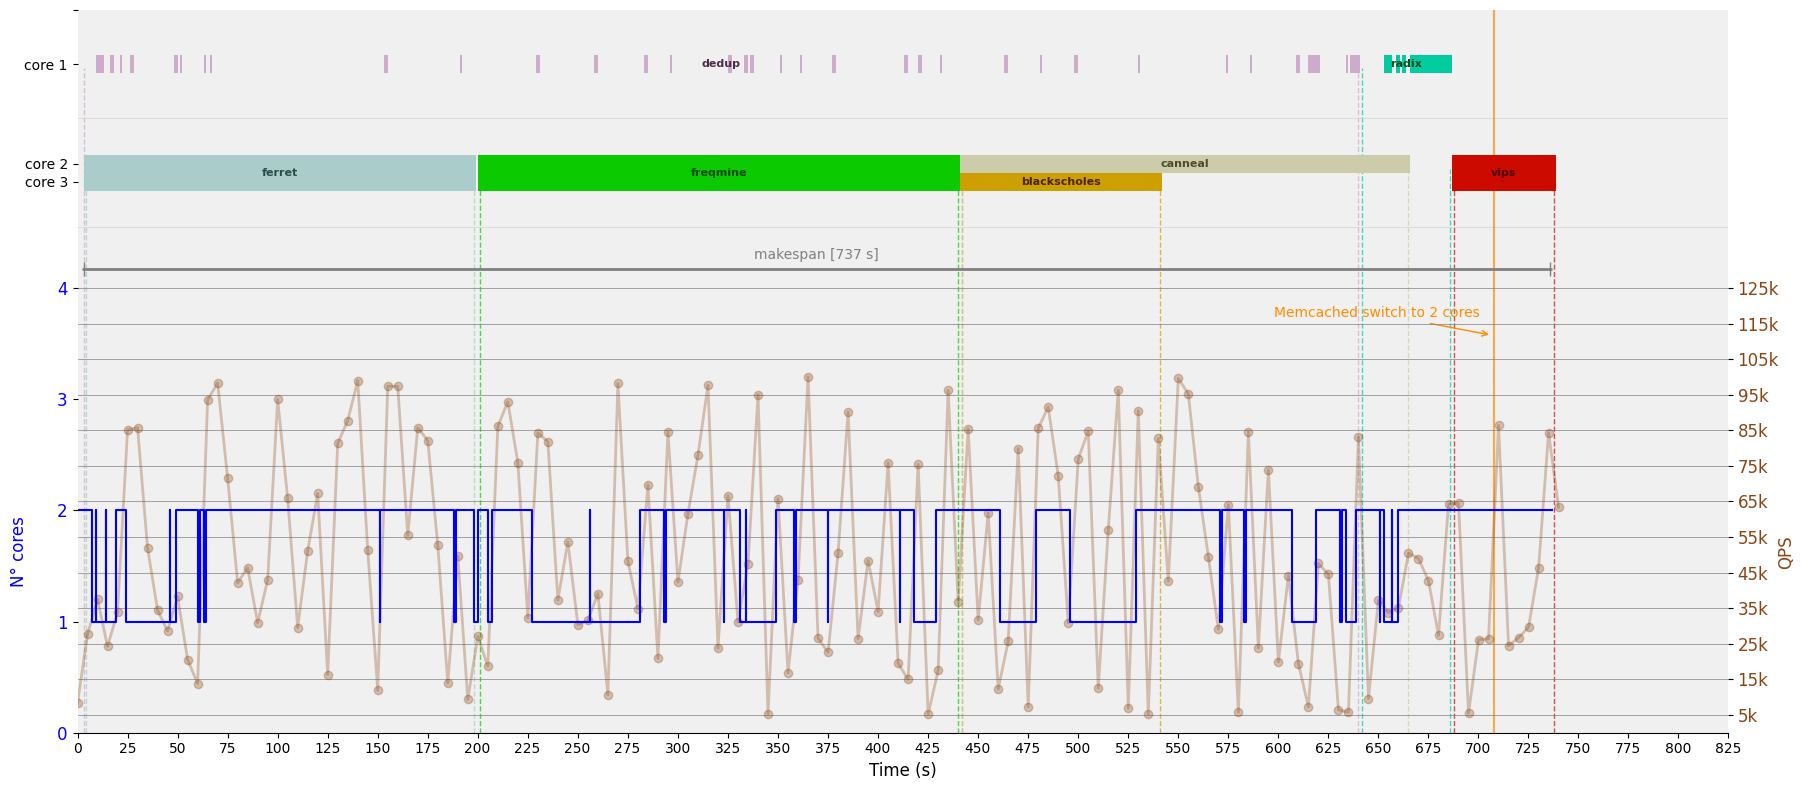

0.0


/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_55264/2103270094.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


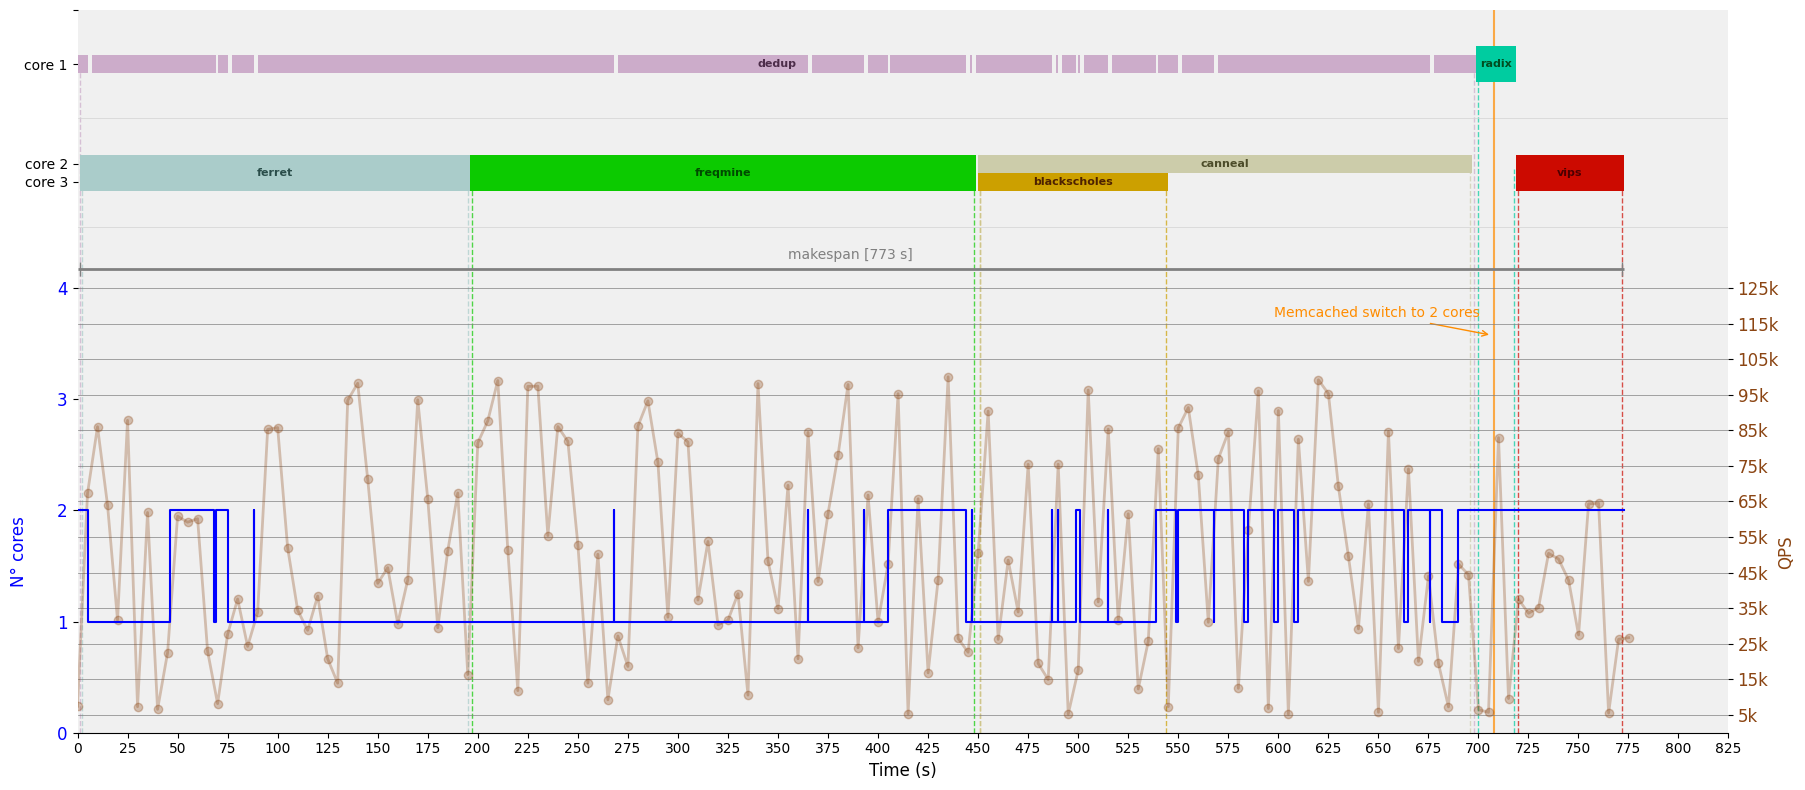

0.0


/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_55264/2103270094.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


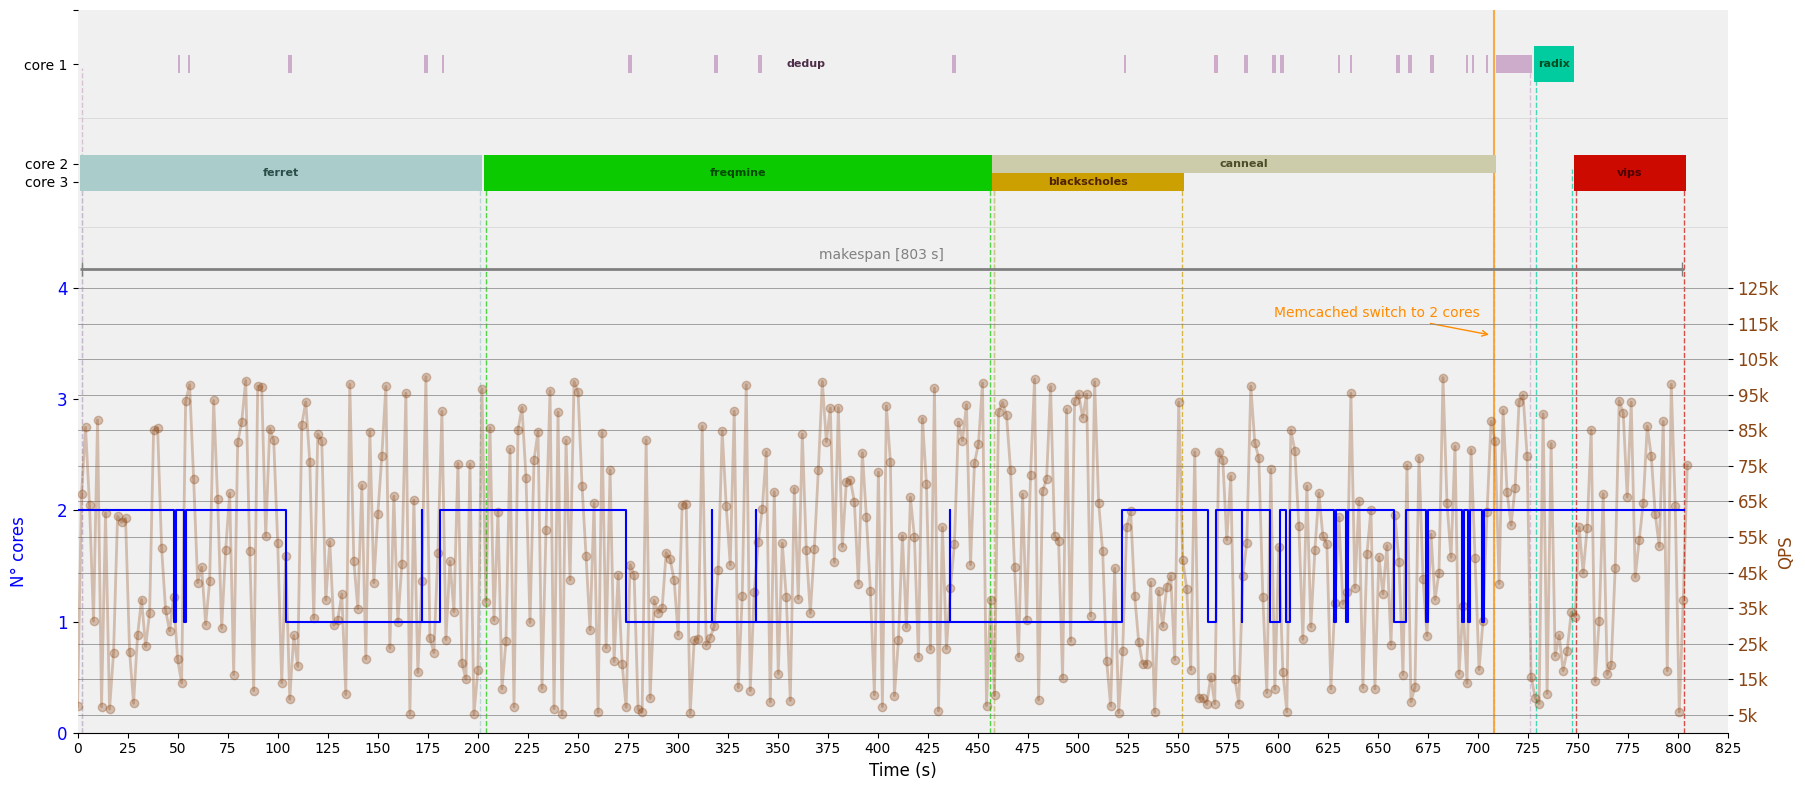

In [103]:
job_colors = {
    'parsec-blackscholes': '#CCA000',
    'parsec-canneal': '#CCCCAA',
    'parsec-dedup': '#CCACCA',
    'parsec-ferret': '#AACCCA',
    'parsec-freqmine': '#0CCA00',
    'parsec-radix': '#00CCA0',
    'parsec-vips': '#CC0A00'
}
job_lim = {
    'parsec-blackscholes': 0.78,
    'parsec-canneal': 0.78,
    'parsec-dedup': 0.92,
    'parsec-ferret': 0.78,
    'parsec-freqmine': 0.78,
    'parsec-radix': [0.92,0.78],
    'parsec-vips': 0.78,
    'memcached': 'grey'
}
def darken_color(color):
    r, g, b = colors.to_rgb(color)
    new_r = max(0, r - 0.5)
    new_g = max(0, g - 0.5)
    new_b = max(0, b - 0.5)
    darker_color = (new_r, new_g, new_b)
    return darker_color

def plot_combined_plot(mcperf_df, pods_df, run_folder, dist, jobs, total, mem_df):
    general_s = total[0]
    print(general_s)
    fig, ax1 = plt.subplots(figsize=(18, 8))
    ax1.set_facecolor('#F0F0F0') 
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ################################################################
    # step 1 - plot jobs
    ################################################################
    j = jobs.items()
    job_groups = {
        'core 3': ['parsec-ferret', 'parsec-freqmine', 'parsec-blackscholes', 'parsec-canneal'],
        'core 2':[],
        'core 1': ['parsec-dedup','parsec-radix','parsec-vips'],
        '': []
    }
    final_pos = 0
    vertical_spacing = 1.0 
    y_positions = {'core 3': 11.0, 'core 1': 17.0}
    for group_name, group_jobs in job_groups.items():
        for job in group_jobs:
            row = pods_df[pods_df['Job'] == job].iloc[0]
            if row['Job'] in job_colors:
                color = job_colors[row['Job']]
                limit = job_lim[row['Job']]
                j = job[7:]
                if j == 'blackscholes':
                    j = 'black'
                jj = jobs[j]
                if j == 'black':
                    y_positions[group_name] -= 0.5 
                if j== 'canneal':
                    y_positions[group_name] += 1
                if j=='freqmine':
                    final_pos = y_positions[group_name]
                if 'pauses' in jj:
                    pauses = jj['pauses']
                    if j=='radix':
                        for el in pauses:
                            e = pauses[el]
                            s = e[0]
                            f = e[1]
                            if f<switch:
                                ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)
                            if s<switch and f>switch:
                                ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=switch - s, height=1, color=color, zorder=3)
                                ax1.barh(y=final_pos, left=switch, width=f - switch, height=2, color=color, zorder=3)
                            if s>switch and f>switch:
                                ax1.barh(y=final_pos, left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)
                    else:
                        for el in pauses:
                            e = pauses[el]
                            s = e[0]
                            f = e[1]
                            ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)
                else:
                    if j=='vips':
                        y_positions[group_name] = final_pos
                    s = jj['start']
                    f = jj['finish']
                    if j=='black' or j=='canneal':
                        ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)
                    else:
                        ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=2, color=color, zorder=3)

                text_x = (jj['start']+dist.total_seconds() + jj['finish']+dist.total_seconds()) / 2  
                text_y = y_positions[group_name]
                ax1.text(text_x, text_y, job[7:], ha='center', va='center', color=darken_color(color), fontsize=8, fontweight='bold')
                if j=='radix':
                    ax1.axvline(x=jj['start']+dist.total_seconds()+1, ymin=0,ymax=limit[0],color=color, linestyle='--', alpha=0.7, linewidth=1)
                    ax1.axvline(x=jj['finish']+dist.total_seconds()-1,  ymin=0,ymax=limit[1],color=color, linestyle='--', alpha=0.7, linewidth=1)
                else:
                    ax1.axvline(x=jj['start']+dist.total_seconds()+1, ymin=0,ymax=limit,color=color, linestyle='--', alpha=0.7, linewidth=1)
                    ax1.axvline(x=jj['finish']+dist.total_seconds()-1,  ymin=0,ymax=limit,color=color, linestyle='--', alpha=0.7, linewidth=1)
        
    ax1.set_ylim(-20)
    ax1.set_yticks([10.5,11.5, 17.0, 20])
    ax1.set_yticklabels(list(job_groups.keys()))
    tray_y_positions = [8, 14.0]
    for y_pos in tray_y_positions:
        ax1.axhline(y=y_pos, color='lightgray', linewidth=0.5)
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_xticks(range(0,850,25))
    ax1.set_xlim(0,825)
    ax1.axvline(x=switch, color='darkorange', alpha=0.7)
    ax1.annotate('Memcached switch to 2 cores', xy=(switch-1, 2), 
             xytext=(switch - 110, 3),
             arrowprops=dict(color='darkorange', arrowstyle='->'), color='darkorange')

    ################################################################
    # step 2 - QPS ON RIGHT
    ax2 = ax1.twinx()
    ax2.set_ylim(0, 203.125) 
    ax2.set_yticks(range(5, 135, 10))
    ax2.set_yticklabels([f'{int(x)}k' for x in range(5, 135, 10)], fontsize=12,color='saddlebrown')
    mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()
    ax2.plot(mcperf_df['left'], mcperf_df['QPS']/1000, 'o-', label='95th Percentile Latency (ms)', alpha=0.3, color='saddlebrown', linewidth=2)
    ax2.set_ylabel('QPS', fontsize=12, color='saddlebrown', alpha=1)
    ax2.yaxis.set_label_coords(1.03,0.25)

    ################################################################
    # step 3 - P95 ON LEFT
    ax3 = ax1.twinx()
    ax3.set_ylim(0, 6.5)
    ax3.set_yticks([0, 1, 2, 3, 4]) 
    ax3.set_yticklabels(['0', '1', '2', '3', '4'], fontsize=12, color='blue') 
    ax3.set_ylabel('N° cores', fontsize=12, color='blue')
    ax3.yaxis.set_label_position('left')
    ax3.yaxis.set_label_coords(-0.030,0.25)
    ax3.yaxis.tick_left()
    mem_df['plot'] = mem_df['timestamp']
    extended_values = {'plot': [total[1]], 'value': [2]}
    extended_df = pd.DataFrame(extended_values)
    mem_df_extended = pd.concat([mem_df, extended_df], ignore_index=True)
    ax3.step(mem_df_extended['plot'], mem_df_extended['value'], where='post', color='blue')

    maxt=total[1]
    ax3.hlines(y=4.17, xmin=dist.total_seconds(), xmax=maxt, color='gray', linewidth=2)
    ax3.text((dist.total_seconds() + maxt) / 2, 4.30, f'makespan [{int(maxt)} s]', horizontalalignment='center', verticalalignment='center', color='gray')
    ax3.plot(dist.total_seconds()+1, 4.17, marker='|', markersize=10, color='gray')
    ax3.plot(maxt-1, 4.17, marker='|', markersize=10, color='gray')

    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # Add horizontal grid lines only on the right side
    ax2.grid(axis='y', which='major', color='grey', linewidth=0.5)

    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)

    plt.tight_layout()
    plt.show()
for i, run_folder in enumerate(['run1','run2', 'run3']):
    plot_combined_plot(all_mcperf_data2[i], all_pods_data[i], run_folder, distances[i], total_jobs[i],total[i], total_mem_to[i])
